# DB2 Data Migration Performance Model

## Introduction

In this project, we aim to predict the performance of database transfers based on various system and transfer-related parameters. We utilize performance benchmark datasets from nine different experiments to train and evaluate several machine learning models. The target variable for our prediction is the `TotaltransferTime`.

The steps involved in this project are as follows:  
1. [Data Loading and Concatenation](#1-data-loading-and-concatenation): Load performance data from nine experiments and concatenate them into a single DataFrame.  
2. [Feature Engineering](#2-feature-engineering): Aggregate relevant table statistics and add them to the main DataFrame.  
3. [Data Cleaning](#3-data-cleaning): Remove duplicate rows and handle missing values.  
4. [Data Visualization Preprocessing](#4-data-visualization-preprocessing): Visualize preprocessed data to understand correlations and distributions.  
5. [Preprocessing](#5-preprocessing): Create preprocessing pipelines for numerical and categorical data.  
6. [Model Selection and Training](#6-model-selection-and-training): Train multiple machine learning models and evaluate their performance.  
7. [Visualizing the Performance](#7-visualizing-the-Performance): Visualization of the top performing models and their specific SHAP analyze graphs.
8. [Evaluation](#8-evaluation): Evaluating the performance using the test set.  


## 1. Data Loading and Concatenation

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform
import dalex as dx
import matplotlib.pyplot as plt
import yaml
import requests


Declairing all the tables that we use in the experiemtns.

In [2]:
tables = {
    'Table name': ["LINEITEM1", "GIGANTICORDERS", "ORDERS2", "ORDERS3", "ORDERS4", "ORDERS5", "ORDERS6", "ORDERS7", "ORDERS8", "ORDERS10", "ORDERSWIDE2"],
    'Data size(MB)': [674, 5477, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 275, 5337],
    'number of rows': [3894493, 45000000, 15000000, 15000000, 15000000, 15000000, 15000000, 15000000,  15000000, 1993416, 15000000],
    'number of columns': [16, 9, 9, 9, 9, 9, 9, 9, 9, 9, 27]
    }

tables_df = pd.DataFrame(tables)
tables_df.head()

,Table name,Data size(MB),number of rows,number of columns
0,LINEITEM1,674,3894493,16
1,GIGANTICORDERS,5477,45000000,9
2,ORDERS2,1825,15000000,9
3,ORDERS3,1825,15000000,9
4,ORDERS4,1825,15000000,9


The system configuation for the first 24 experiemnts.

In [3]:
source_machine_specs = {
    'RAM (GB)': [120],
    'CPU': [16],
    'Disk (GB)': [20],
    'External Disk (GB)': [576]
    }

source_machine_df = pd.DataFrame(source_machine_specs)
source_machine_df.head()

,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,120,16,20,576


In [4]:
# Function to extract numeric part from RAM string (e.g. "10g" -> 10)
def extract_ram_value(ram_str):
    return float(''.join(filter(str.isdigit, ram_str)))

The system configuration for the 9 experiemtns in version 2 experiments.

In [5]:
# List of URLs containing YAML files
urls = [
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp1/docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp2/docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp3/docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp4/docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp5/docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp6/docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp7/docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp8/docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp9/docker-compose.yml"
]


# List to store the parsed CPU and memory information from each YAML
parsed_yaml_data = []

# Loop through each URL and fetch YAML content
for url in urls:
    try:
        # Fetch the content of the YAML file
        response = requests.get(url)
        
        # Check if the request was successful
        if response.status_code == 200:
            # Parse YAML content
            yaml_content = yaml.safe_load(response.text)
            
            # Check if 'deploy' and resource limits are present, otherwise use source_machine_df values
            if 'deploy' in yaml_content['services']['web'] and 'resources' in yaml_content['services']['web']['deploy']:
                # Extract 'cpus' and 'memory' (ram) limits from YAML or use machine's full capacity
                cpus = yaml_content['services']['web']['deploy']['resources']['limits'].get('cpus', source_machine_df["CPU"].values[0])
                print(cpus)
                cpus = float(cpus) / source_machine_df["CPU"].values[0]

                ram = yaml_content['services']['web']['deploy']['resources']['limits'].get('memory', f'{source_machine_df["RAM (GB)"].values[0]}g')
                ram_value = extract_ram_value(ram)  # Extract only the numeric part
            else:
                # If 'deploy' or resource limits are missing, use the entire source_machine_df values
                cpus = source_machine_df["CPU"].values[0]  # Access the first value
                ram_value = source_machine_df["RAM (GB)"].values[0]  # Access the first value
            
            # Append the extracted information as a dictionary to the list
            parsed_yaml_data.append({'CPU': cpus, 'RAM (GB)': ram_value})
            print(f"Successfully fetched and parsed: {url}")
        else:
            print(f"Failed to fetch {url}. Status code: {response.status_code}")
    except Exception as e:
        print(f"Error while fetching {url}: {e}")

yaml_df = pd.DataFrame(parsed_yaml_data)

# Optionally, inspect the new DataFrame
# print("New DataFrame created from YAML content:")
# print(yaml_df)

0.1
Successfully fetched and parsed: https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp1/docker-compose.yml
0.05
Successfully fetched and parsed: https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp2/docker-compose.yml
0.05
Successfully fetched and parsed: https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp3/docker-compose.yml
Successfully fetched and parsed: https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp4/docker-compose.yml
0.05
Successfully fetched and parsed: https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp5/docker-compose.yml
0.1
Successfully fetched and parsed: https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp6/docker-compose.yml
0.1
Successfully 

test set

In [6]:
test_urls = [
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp56/docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp57/docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp58/docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp59/docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp60/docker-compose.yml"
]

parsed_yaml_data = []

for url in test_urls:
    try:
        response = requests.get(url)
        if response.status_code == 200:
            yaml_content = yaml.safe_load(response.text)
            if 'deploy' in yaml_content['services']['web'] and 'resources' in yaml_content['services']['web']['deploy']:
                cpus = yaml_content['services']['web']['deploy']['resources']['limits'].get('cpus', source_machine_df["CPU"].values[0])
                cpus = float(cpus) / source_machine_df["CPU"].values[0]
                ram = yaml_content['services']['web']['deploy']['resources']['limits'].get('memory', f'{source_machine_df["RAM (GB)"].values[0]}g')
                ram_value = extract_ram_value(ram)
            else:
                cpus = source_machine_df["CPU"].values[0]
                ram_value = source_machine_df["RAM (GB)"].values[0]

            parsed_yaml_data.append({'CPU': cpus, 'RAM (GB)': ram_value})
        else:
            print(f"Failed to fetch {url}. Status code: {response.status_code}")
    except Exception as e:
        print(f"Error while fetching {url}: {e}")

test_yaml_df = pd.DataFrame(parsed_yaml_data)


In [7]:
test_yaml_df

,CPU,RAM (GB)
0,0.625,10.0
1,0.625,10.0
2,0.625,10.0
3,0.625,10.0
4,0.625,10.0


In [8]:
test1_url = ["https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp56/docker-compose.yml",
             "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp65/docker-compose.yml"]

parsed_yaml_data = []

for url in test1_url:
    try:
        response = requests.get(url)
        if response.status_code == 200:
            yaml_content = yaml.safe_load(response.text)
            if 'deploy' in yaml_content['services']['web'] and 'resources' in yaml_content['services']['web']['deploy']:
                cpus = yaml_content['services']['web']['deploy']['resources']['limits'].get('cpus', source_machine_df["CPU"].values[0])
                cpus = float(cpus) / source_machine_df["CPU"].values[0]
                ram = yaml_content['services']['web']['deploy']['resources']['limits'].get('memory', f'{source_machine_df["RAM (GB)"].values[0]}g')
                ram_value = extract_ram_value(ram)
            else:
                cpus = source_machine_df["CPU"].values[0]
                ram_value = source_machine_df["RAM (GB)"].values[0]

            parsed_yaml_data.append({'CPU': cpus, 'RAM (GB)': ram_value})
        else:
            print(f"Failed to fetch {url}. Status code: {response.status_code}")
    except Exception as e:
        print(f"Error while fetching {url}: {e}")

test1_yaml_df = pd.DataFrame(parsed_yaml_data)


In [9]:
test1_yaml_df

,CPU,RAM (GB)
0,0.6250,10.0
1,0.0625,10.0


In [10]:
# print(yaml['services']['web']['deploy']['resources']['limits']['cpus'])
yaml_df


,CPU,RAM (GB)
0,0.006250,10.0
1,0.003125,10.0
2,0.003125,10.0
3,16.000000,120.0
4,0.003125,10.0
5,0.006250,10.0
6,0.006250,10.0
7,0.003125,10.0
8,0.003125,10.0


Importing the experiments.

In [11]:
# Load the performance benchmark datasets
exp1_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp1/performanceBenchmark.csv')
exp2_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp2/performanceBenchmark.csv')
exp3_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp3/performanceBenchmark.csv')
exp4_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp4/performanceBenchmark.csv')
exp5_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp5/performanceBenchmark.csv')
exp6_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp6/performanceBenchmark.csv')
exp7_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp7/performanceBenchmark.csv')
exp8_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp8/performanceBenchmark.csv')
exp9_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp9/performanceBenchmark.csv')
exp10_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp10/performanceBenchmark.csv')
exp11_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp11/performanceBenchmark.csv')
exp12_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp12/performanceBenchmark.csv')
exp13_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp13/performanceBenchmark.csv')
exp14_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp14/performanceBenchmark.csv')
exp15_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp15/performanceBenchmark.csv')
exp16_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp16/performanceBenchmark.csv')
exp17_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp17/performanceBenchmark.csv')
exp18_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp18/performanceBenchmark.csv')
exp19_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp19/performanceBenchmark.csv')
exp20_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp20/performanceBenchmark.csv')
exp21_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp21/performanceBenchmark.csv')
exp22_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp22/performanceBenchmark.csv')
exp23_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp23/performanceBenchmark.csv')
exp24_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp24/performanceBenchmark.csv')
v2_exp1_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp1/performanceBenchmark.csv')
v2_exp2_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp2/performanceBenchmark.csv')
v2_exp3_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp3/performanceBenchmark.csv')
v2_exp4_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp4/performanceBenchmark.csv')
v2_exp5_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp5/performanceBenchmark.csv')
v2_exp6_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp6/performanceBenchmark.csv')
v2_exp7_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp7/performanceBenchmark.csv')
v2_exp8_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp8/performanceBenchmark.csv')
v2_exp9_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp9/performanceBenchmark.csv')

# New DMBnech version experiments
v4_exp72_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v4/exp72/performanceBenchmark.csv')
v4_exp73_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v4/exp73/performanceBenchmark.csv')

# Load test performance benchmark datasets
v3_exp56_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp56/performanceBenchmark.csv')
v3_exp57_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp57/performanceBenchmark.csv')
v3_exp58_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp58/performanceBenchmark.csv')
v3_exp59_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp59/performanceBenchmark.csv')
v3_exp60_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp60/performanceBenchmark.csv')
v3_exp65_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v3/exp65/performanceBenchmark.csv')

In [12]:
exp1_performance_df.head()

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime
0,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,3296.018193,3266.620216,32.906244,NaN
1,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,622.369466,588.320576,3.208371,NaN
2,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,1945.972293,1920.935266,3.742569,NaN
3,4,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,3834.102760,3783.924402,6.611556,NaN
4,5,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,1933.460342,1901.642637,6.197286,NaN


In [13]:
print(exp10_performance_df.columns)

Index(['Experiment Number', 'compress', 'sourceDatabasetoTargetDatabase',
       'tables', 'maxStreams', 'binary', 'Experiment startTime',
       'TotalExperimentTime', 'TotaltransferTime', 'totalPrecheckTime',
       'TotalClearTime'],
      dtype='object')


In [14]:
v2_exp8_performance_df.drop(v2_exp8_performance_df.tail(1).index, inplace=True)
v2_exp8_performance_df.tail(10)

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime
4,5,NO,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726169e+09,5308.884032,4550.101039,247.407962,6.561349
5,1,GZIP,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726203e+09,4449.286099,3703.900795,289.613249,4.588818
6,2,GZIP,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726203e+09,5666.211861,4878.199970,245.691966,41.705382
7,3,GZIP,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726203e+09,4073.898144,3315.093996,284.016738,5.839195
8,4,GZIP,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726203e+09,5038.388140,4293.599903,227.205449,3.987905
9,5,GZIP,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726203e+09,3970.035422,3166.298856,246.810068,46.200249
10,1,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,3959.046351,3031.400081,184.198949,191.827737
11,2,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,4251.160840,3268.497884,239.703630,236.805045
12,3,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,5961.989170,5473.799116,228.695376,334.928746
13,4,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,5150.957639,4401.501568,232.703128,4.992518


In [15]:
# Assuming `v2_performance_dfs` contains the list of dataframes and `yaml_df` contains the extracted CPU/RAM values
v2_performance_dfs = [v2_exp1_performance_df, v2_exp2_performance_df, v2_exp3_performance_df,
                      v2_exp4_performance_df, v2_exp5_performance_df, v2_exp6_performance_df,
                      v2_exp7_performance_df, v2_exp8_performance_df, v2_exp9_performance_df]

# Extract the Disk and External Disk values from `source_machine_df`
disk_value = source_machine_df['Disk (GB)'].values[0]
external_disk_value = source_machine_df['External Disk (GB)'].values[0]

# Loop over each DataFrame and the corresponding row from yaml_df
extended_dfs = []  # To store the extended DataFrames

for i, df in enumerate(v2_performance_dfs):
    # Get the corresponding row from yaml_df (i-th row)
    yaml_row = yaml_df.iloc[i]
    
    # Repeat the values of yaml_row for the number of rows in the respective performance DataFrame
    repeated_yaml_row = pd.DataFrame([yaml_row] * len(df), index=df.index)
    
    # Add the Disk and External Disk values to every row of the DataFrame
    repeated_yaml_row['Disk (GB)'] = disk_value
    repeated_yaml_row['External Disk (GB)'] = external_disk_value
    
    # Concatenate the repeated yaml_row with the current performance DataFrame
    extended_df = pd.concat([df, repeated_yaml_row], axis=1)
    
    # Add the extended DataFrame to the list
    extended_dfs.append(extended_df)

# Combine all the extended DataFrames into one
v2_performance_df = pd.concat(extended_dfs, ignore_index=True)


In [16]:
v2_performance_df

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime,CPU,RAM (GB),Disk (GB),External Disk (GB)
0,1,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,2078.446037,1316.606168,254.308353,2.999866,0.006250,10.0,20,576
1,2,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,1804.069990,1047.599877,307.916508,5.783820,0.006250,10.0,20,576
2,3,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,1799.690132,0.000000,0.000000,56.280673,0.006250,10.0,20,576
3,4,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,1386.654521,1168.301981,276.305505,46.940669,0.006250,10.0,20,576
4,5,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,927.905531,0.000000,246.076808,68.022536,0.006250,10.0,20,576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,1,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,3959.046351,3031.400081,184.198949,191.827737,0.003125,10.0,20,576
195,2,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,4251.160840,3268.497884,239.703630,236.805045,0.003125,10.0,20,576
196,3,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,5961.989170,5473.799116,228.695376,334.928746,0.003125,10.0,20,576
197,4,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,5150.957639,4401.501568,232.703128,4.992518,0.003125,10.0,20,576


Concatenating all the experiments

In [17]:
performance_dfs = [exp1_performance_df, exp2_performance_df, exp3_performance_df, 
                   exp4_performance_df, exp5_performance_df, exp6_performance_df, 
                   exp7_performance_df, exp8_performance_df, exp9_performance_df,
                   exp10_performance_df, exp11_performance_df, exp12_performance_df,
                   exp13_performance_df, exp14_performance_df, exp15_performance_df,
                   exp16_performance_df, exp17_performance_df, exp18_performance_df,
                   exp19_performance_df, exp20_performance_df, exp21_performance_df,
                   exp22_performance_df, exp23_performance_df, exp24_performance_df]

test_performance_dfs = [v3_exp56_performance_df, v3_exp57_performance_df, v3_exp58_performance_df,
                       v3_exp59_performance_df, v3_exp60_performance_df]

performance_df = pd.concat(performance_dfs, ignore_index=True)
test_performance_df = pd.concat(test_performance_dfs, ignore_index=True)


In [18]:
disk_value = source_machine_df['Disk (GB)'].values[0]
external_disk_value = source_machine_df['External Disk (GB)'].values[0]

extended_dfs = []

for i, df in enumerate([test_performance_df]):
    yaml_row = test_yaml_df.iloc[i]
    repeated_yaml_row = pd.DataFrame([yaml_row] * len(df), index=df.index)
    repeated_yaml_row['Disk (GB)'] = disk_value
    repeated_yaml_row['External Disk (GB)'] = external_disk_value
    extended_df = pd.concat([df, repeated_yaml_row], axis=1)
    extended_dfs.append(extended_df)

final_test_df = pd.concat(extended_dfs, ignore_index=True)


In [19]:
extended_dfs = []
test1_performance_dfs = [v3_exp56_performance_df, v3_exp65_performance_df]
test1_performance_df = pd.concat(test1_performance_dfs, ignore_index=True)

for i, df in enumerate([test1_performance_df]):
    yaml_row = test1_yaml_df.iloc[i]
    repeated_yaml_row = pd.DataFrame([yaml_row] * len(df), index=df.index)
    repeated_yaml_row['Disk (GB)'] = disk_value
    repeated_yaml_row['External Disk (GB)'] = external_disk_value
    extended_df = pd.concat([df, repeated_yaml_row], axis=1)
    extended_dfs.append(extended_df)

final_test1_df = pd.concat(extended_dfs, ignore_index=True)


In [20]:
final_test1_df

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,attempt_number,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime,ExperimentStatus,CPU,RAM (GB),Disk (GB),External Disk (GB)
0,1,LZ4,testdb_testdb,dummy,5,False,1,1.728233e+09,4225.408488,4187.231303,0,12.101315,True,0.625,10.0,20,576
1,1,LZ4,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,1,1.728233e+09,6658.204021,6614.089232,0,19.745839,True,0.625,10.0,20,576
2,2,LZ4,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,1,1.728233e+09,10598.299798,10539.955298,0,23.765125,True,0.625,10.0,20,576
3,3,LZ4,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,1,1.728233e+09,146.789336,0.000000,0,32.852638,False,0.625,10.0,20,576
4,4,LZ4,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,1,1.728233e+09,8886.702877,8799.406026,0,27.777394,True,0.625,10.0,20,576
5,5,LZ4,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,1,1.728233e+09,10016.270847,9924.048079,0,28.285538,True,0.625,10.0,20,576
6,6,LZ4,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,1,1.728233e+09,9782.004497,9702.185297,0,23.412012,True,0.625,10.0,20,576
7,3,LZ4,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,False,2,1.728233e+09,9325.476025,9266.211862,0,4.575902,True,0.625,10.0,20,576
8,1,LZ4,testdb_testdb,dummy,5,False,1,1.728298e+09,5926.975376,5863.146309,0,25.430486,True,0.625,10.0,20,576
9,1,LZ4,testdb_testdb,GIGANTICORDERS,5,False,1,1.728298e+09,28789.044595,28711.608555,0,18.333039,True,0.625,10.0,20,576


In [21]:
performance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Experiment Number               372 non-null    int64  
 1   compress                        372 non-null    object 
 2   sourceDatabasetoTargetDatabase  372 non-null    object 
 3   tables                          372 non-null    object 
 4   maxStreams                      372 non-null    int64  
 5   binary                          372 non-null    bool   
 6   Experiment startTime            372 non-null    float64
 7   TotalExperimentTime             372 non-null    float64
 8   TotaltransferTime               372 non-null    float64
 9   totalPrecheckTime               372 non-null    float64
 10  TotalClearTime                  329 non-null    float64
dtypes: bool(1), float64(5), int64(2), object(3)
memory usage: 29.6+ KB


The `calculate_table_sums` function calculates and aggregates the total data size, number of rows, and number of columns for specified table names within a dataframe. It adds these aggregated values as new features to the original dataframe.

In [22]:
performance_df

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime
0,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,3296.018193,3266.620216,32.906244,NaN
1,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,622.369466,588.320576,3.208371,NaN
2,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,1945.972293,1920.935266,3.742569,NaN
3,4,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,3834.102760,3783.924402,6.611556,NaN
4,5,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,1933.460342,1901.642637,6.197286,NaN
...,...,...,...,...,...,...,...,...,...,...,...
367,3,NO,testdb_testdb,ORDERSWIDE2,5,False,1.719368e+09,587.753326,563.725937,53.784407,2.670337
368,4,NO,testdb_testdb,ORDERSWIDE2,5,False,1.719368e+09,927.081444,907.880295,36.027611,2.575287
369,5,NO,testdb_testdb,ORDERSWIDE2,5,False,1.719368e+09,690.811253,550.628901,35.914018,119.534970
370,6,NO,testdb_testdb,ORDERSWIDE2,5,False,1.719368e+09,542.664062,523.224117,35.282297,2.688195


In [23]:
print("Columns in exp_df:", final_test_df.columns)


Columns in exp_df: Index(['Experiment Number', 'compress', 'sourceDatabasetoTargetDatabase',
       'tables', 'maxStreams', 'binary', 'attempt_number',
       'Experiment startTime', 'TotalExperimentTime', 'TotaltransferTime',
       'totalPrecheckTime', 'TotalClearTime', 'ExperimentStatus', 'CPU',
       'RAM (GB)', 'Disk (GB)', 'External Disk (GB)'],
      dtype='object')


## 2. Feature Engineering

We define a function `calculate_table_sums` to calculate and aggregate the total data size, number of rows, and number of columns for specified table names within the DataFrame.

In [24]:
def calculate_table_sums(exp_df, tables_df):

    # Extract table names
    table_names_series = exp_df['tables'].str.split('_', expand=False)
    
    # Initialize lists to store the sums
    data_size_sum = []
    rows_sum = []
    columns_sum = []
    print(data_size_sum, rows_sum, columns_sum)

    # Iterate over each row of table names
    for table_names in table_names_series:
        # Filter the info dataframe for the current table names
        filtered_info = tables_df[tables_df['Table name'].isin(table_names)]
        # print(filtered_info)
        # Calculate the sums
        data_size_sum.append(filtered_info['Data size(MB)'].sum())
        rows_sum.append(filtered_info['number of rows'].sum())
        columns_sum.append(filtered_info['number of columns'].sum())
        # print(data_size_sum, rows_sum, columns_sum)


    # Add the sums as new features in the initial dataframe
    exp_df['Data size sum (MB)'] = data_size_sum
    exp_df['Number of rows sum'] = rows_sum
    exp_df['Number of columns sum'] = columns_sum

    
    exp_df = exp_df[['Experiment Number', 'compress', 'sourceDatabasetoTargetDatabase', 'tables', 'Data size sum (MB)', 
                     'Number of rows sum', 'Number of columns sum', 'maxStreams', 'binary', 'Experiment startTime', 
                     'TotalExperimentTime', 'TotaltransferTime', 'totalPrecheckTime', 'TotalClearTime', 'RAM (GB)',	'CPU', 'Disk (GB)', 'External Disk (GB)']]

    return exp_df

In [25]:
final_test_df = calculate_table_sums(final_test_df, tables_df)

[] [] []


In [26]:
final_test1_df = calculate_table_sums(final_test1_df, tables_df)

[] [] []


In [27]:
final_test_df

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,1,LZ4,testdb_testdb,dummy,0,0,0,5,False,1.728233e+09,4225.408488,4187.231303,0,1.210132e+01,10.0,0.625,20,576
1,1,LZ4,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,5,False,1.728233e+09,6658.204021,6614.089232,0,1.974584e+01,10.0,0.625,20,576
2,2,LZ4,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,5,False,1.728233e+09,10598.299798,10539.955298,0,2.376512e+01,10.0,0.625,20,576
3,3,LZ4,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,5,False,1.728233e+09,146.789336,0.000000,0,3.285264e+01,10.0,0.625,20,576
4,4,LZ4,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,5,False,1.728233e+09,8886.702877,8799.406026,0,2.777739e+01,10.0,0.625,20,576
5,5,LZ4,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,5,False,1.728233e+09,10016.270847,9924.048079,0,2.828554e+01,10.0,0.625,20,576
6,6,LZ4,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,5,False,1.728233e+09,9782.004497,9702.185297,0,2.341201e+01,10.0,0.625,20,576
7,3,LZ4,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,2774,20887909,34,5,False,1.728233e+09,9325.476025,9266.211862,0,4.575902e+00,10.0,0.625,20,576
8,1,LZ4,testdb_testdb,dummy,0,0,0,5,False,1.728298e+09,5926.975376,5863.146309,0,2.543049e+01,10.0,0.625,20,576
9,1,LZ4,testdb_testdb,GIGANTICORDERS,5477,45000000,9,5,False,1.728298e+09,28789.044595,28711.608555,0,1.833304e+01,10.0,0.625,20,576


In [28]:
performance_df

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime
0,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,3296.018193,3266.620216,32.906244,NaN
1,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,622.369466,588.320576,3.208371,NaN
2,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,1945.972293,1920.935266,3.742569,NaN
3,4,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,3834.102760,3783.924402,6.611556,NaN
4,5,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,1933.460342,1901.642637,6.197286,NaN
...,...,...,...,...,...,...,...,...,...,...,...
367,3,NO,testdb_testdb,ORDERSWIDE2,5,False,1.719368e+09,587.753326,563.725937,53.784407,2.670337
368,4,NO,testdb_testdb,ORDERSWIDE2,5,False,1.719368e+09,927.081444,907.880295,36.027611,2.575287
369,5,NO,testdb_testdb,ORDERSWIDE2,5,False,1.719368e+09,690.811253,550.628901,35.914018,119.534970
370,6,NO,testdb_testdb,ORDERSWIDE2,5,False,1.719368e+09,542.664062,523.224117,35.282297,2.688195


In [29]:
v2_performance_df

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime,CPU,RAM (GB),Disk (GB),External Disk (GB)
0,1,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,2078.446037,1316.606168,254.308353,2.999866,0.006250,10.0,20,576
1,2,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,1804.069990,1047.599877,307.916508,5.783820,0.006250,10.0,20,576
2,3,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,1799.690132,0.000000,0.000000,56.280673,0.006250,10.0,20,576
3,4,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,1386.654521,1168.301981,276.305505,46.940669,0.006250,10.0,20,576
4,5,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,927.905531,0.000000,246.076808,68.022536,0.006250,10.0,20,576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,1,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,3959.046351,3031.400081,184.198949,191.827737,0.003125,10.0,20,576
195,2,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,4251.160840,3268.497884,239.703630,236.805045,0.003125,10.0,20,576
196,3,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,5961.989170,5473.799116,228.695376,334.928746,0.003125,10.0,20,576
197,4,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,5150.957639,4401.501568,232.703128,4.992518,0.003125,10.0,20,576


In [30]:
# Concatenate the experiment tables with the system specs
df2_repeated = pd.concat([source_machine_df]*len(performance_df), ignore_index=True)


result_df = pd.concat([performance_df, df2_repeated], axis=1)

In [31]:
# Ensure that both DataFrames have the same column order
v2_performance_df = v2_performance_df[result_df.columns]

# Concatenate the two DataFrames
result_df = pd.concat([v2_performance_df, result_df], ignore_index=True)



In [32]:
result_df.head(20)

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,1,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,2078.446037,1316.606168,254.308353,2.999866,10.0,0.00625,20,576
1,2,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,1804.069990,1047.599877,307.916508,5.783820,10.0,0.00625,20,576
2,3,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,1799.690132,0.000000,0.000000,56.280673,10.0,0.00625,20,576
3,4,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,1386.654521,1168.301981,276.305505,46.940669,10.0,0.00625,20,576
4,5,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,927.905531,0.000000,246.076808,68.022536,10.0,0.00625,20,576
5,6,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,2442.184753,1680.701212,297.409373,2.359228,10.0,0.00625,20,576
6,7,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,1301.701983,1097.199158,330.917276,34.045334,10.0,0.00625,20,576
7,1,GZIP,testdb_testdb,GIGANTICORDERS,5,True,1.725087e+09,2906.590192,2689.705929,328.312150,59.996442,10.0,0.00625,20,576
8,2,GZIP,testdb_testdb,GIGANTICORDERS,5,True,1.725087e+09,2820.139517,2432.704535,302.293489,235.848617,10.0,0.00625,20,576
9,3,GZIP,testdb_testdb,GIGANTICORDERS,5,True,1.725087e+09,3909.006256,3014.900997,282.703190,131.074699,10.0,0.00625,20,576


In [33]:
result_df = calculate_table_sums(result_df, tables_df)

[] [] []


In [34]:
result_df.drop(labels=['Experiment Number', 'sourceDatabasetoTargetDatabase', 'tables', 
                            'TotalExperimentTime', 'totalPrecheckTime', 'TotalClearTime', 
                            'Experiment startTime'], axis=1, inplace=True)

In [35]:
final_test1_df = final_test1_df.drop(final_test1_df[final_test1_df['tables'] == 'dummy'].index)

In [36]:
final_test_df = final_test_df.drop(final_test_df[final_test_df['tables'] == 'dummy'].index)

In [37]:
final_test_df.drop(labels=['Experiment Number', 'sourceDatabasetoTargetDatabase', 'tables', 
                            'TotalExperimentTime', 'totalPrecheckTime', 'TotalClearTime', 
                            'Experiment startTime'], axis=1, inplace=True)

In [38]:
final_test1_df.drop(labels=['Experiment Number', 'sourceDatabasetoTargetDatabase', 'tables', 
                            'TotalExperimentTime', 'totalPrecheckTime', 'TotalClearTime', 
                            'Experiment startTime'], axis=1, inplace=True)

In [39]:
result_df

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,GZIP,2774,20887909,34,5,True,1316.606168,10.0,0.00625,20,576
1,GZIP,2774,20887909,34,5,True,1047.599877,10.0,0.00625,20,576
2,GZIP,2774,20887909,34,5,True,0.000000,10.0,0.00625,20,576
3,GZIP,2774,20887909,34,5,True,1168.301981,10.0,0.00625,20,576
4,GZIP,2774,20887909,34,5,True,0.000000,10.0,0.00625,20,576
...,...,...,...,...,...,...,...,...,...,...,...
566,NO,5337,15000000,27,5,False,563.725937,120.0,16.00000,20,576
567,NO,5337,15000000,27,5,False,907.880295,120.0,16.00000,20,576
568,NO,5337,15000000,27,5,False,550.628901,120.0,16.00000,20,576
569,NO,5337,15000000,27,5,False,523.224117,120.0,16.00000,20,576


## 3. Data Cleaning

### 3.1 Check for duplicate rows and remove them if any.

In [40]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   compress               571 non-null    object 
 1   Data size sum (MB)     571 non-null    int64  
 2   Number of rows sum     571 non-null    int64  
 3   Number of columns sum  571 non-null    int64  
 4   maxStreams             571 non-null    int64  
 5   binary                 571 non-null    bool   
 6   TotaltransferTime      571 non-null    float64
 7   RAM (GB)               571 non-null    float64
 8   CPU                    571 non-null    float64
 9   Disk (GB)              571 non-null    int64  
 10  External Disk (GB)     571 non-null    int64  
dtypes: bool(1), float64(3), int64(6), object(1)
memory usage: 45.3+ KB


In [41]:
result_df.duplicated().sum()

45

In [42]:
result_df.drop_duplicates(inplace=True)

### 3.2 Handle the missing values

In [43]:
result_df.isna().sum()

compress                 0
Data size sum (MB)       0
Number of rows sum       0
Number of columns sum    0
maxStreams               0
binary                   0
TotaltransferTime        0
RAM (GB)                 0
CPU                      0
Disk (GB)                0
External Disk (GB)       0
dtype: int64

In [44]:
result_df

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,GZIP,2774,20887909,34,5,True,1316.606168,10.0,0.00625,20,576
1,GZIP,2774,20887909,34,5,True,1047.599877,10.0,0.00625,20,576
2,GZIP,2774,20887909,34,5,True,0.000000,10.0,0.00625,20,576
3,GZIP,2774,20887909,34,5,True,1168.301981,10.0,0.00625,20,576
5,GZIP,2774,20887909,34,5,True,1680.701212,10.0,0.00625,20,576
...,...,...,...,...,...,...,...,...,...,...,...
566,NO,5337,15000000,27,5,False,563.725937,120.0,16.00000,20,576
567,NO,5337,15000000,27,5,False,907.880295,120.0,16.00000,20,576
568,NO,5337,15000000,27,5,False,550.628901,120.0,16.00000,20,576
569,NO,5337,15000000,27,5,False,523.224117,120.0,16.00000,20,576


In [45]:
result_df = result_df.drop(result_df[result_df['TotaltransferTime'] == 0].index)


In [46]:
result_df

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,GZIP,2774,20887909,34,5,True,1316.606168,10.0,0.00625,20,576
1,GZIP,2774,20887909,34,5,True,1047.599877,10.0,0.00625,20,576
3,GZIP,2774,20887909,34,5,True,1168.301981,10.0,0.00625,20,576
5,GZIP,2774,20887909,34,5,True,1680.701212,10.0,0.00625,20,576
6,GZIP,2774,20887909,34,5,True,1097.199158,10.0,0.00625,20,576
...,...,...,...,...,...,...,...,...,...,...,...
566,NO,5337,15000000,27,5,False,563.725937,120.0,16.00000,20,576
567,NO,5337,15000000,27,5,False,907.880295,120.0,16.00000,20,576
568,NO,5337,15000000,27,5,False,550.628901,120.0,16.00000,20,576
569,NO,5337,15000000,27,5,False,523.224117,120.0,16.00000,20,576


In [47]:
result_df.reset_index(drop=True, inplace=True)

In [48]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   compress               490 non-null    object 
 1   Data size sum (MB)     490 non-null    int64  
 2   Number of rows sum     490 non-null    int64  
 3   Number of columns sum  490 non-null    int64  
 4   maxStreams             490 non-null    int64  
 5   binary                 490 non-null    bool   
 6   TotaltransferTime      490 non-null    float64
 7   RAM (GB)               490 non-null    float64
 8   CPU                    490 non-null    float64
 9   Disk (GB)              490 non-null    int64  
 10  External Disk (GB)     490 non-null    int64  
dtypes: bool(1), float64(3), int64(6), object(1)
memory usage: 38.9+ KB


In [49]:
list_of_compress = result_df['compress'].unique()
list_of_maxSream = result_df['maxStreams'].unique()
list_of_binary = result_df['binary'].unique()
list_of_RAM = result_df['RAM (GB)'].unique()
list_of_CPU = result_df['CPU'].unique()

print(f"compression list: {list_of_compress}")
print(f"maxSream list: {list_of_maxSream}")
print(f"binary list: {list_of_binary}")
print(f"RAM list: {list_of_RAM}")
print(f"CPU list: {list_of_CPU}")

compression list: ['GZIP' 'LZ4' 'NO']
maxSream list: [ 5  1 10]
binary list: [ True False]
RAM list: [ 10. 120.]
CPU list: [6.250e-03 3.125e-03 1.600e+01]


In [50]:
final_test_df.drop_duplicates(inplace=True)
final_test_df = final_test_df.drop(final_test_df[final_test_df['TotaltransferTime'] == 0].index)

final_test_df.reset_index(drop=True, inplace=True)


In [51]:
final_test1_df.drop_duplicates(inplace=True)
final_test1_df = final_test1_df.drop(final_test1_df[final_test1_df['TotaltransferTime'] == 0].index)

final_test1_df.reset_index(drop=True, inplace=True)


In [52]:
final_test_df

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,LZ4,2774,20887909,34,5,False,6614.089232,10.0,0.625,20,576
1,LZ4,2774,20887909,34,5,False,10539.955298,10.0,0.625,20,576
2,LZ4,2774,20887909,34,5,False,8799.406026,10.0,0.625,20,576
3,LZ4,2774,20887909,34,5,False,9924.048079,10.0,0.625,20,576
4,LZ4,2774,20887909,34,5,False,9702.185297,10.0,0.625,20,576
5,LZ4,2774,20887909,34,5,False,9266.211862,10.0,0.625,20,576
6,LZ4,5477,45000000,9,5,False,28711.608555,10.0,0.625,20,576
7,LZ4,5477,45000000,9,5,False,30522.033113,10.0,0.625,20,576
8,LZ4,5477,45000000,9,5,False,28353.734039,10.0,0.625,20,576
9,LZ4,5477,45000000,9,5,False,18800.444881,10.0,0.625,20,576


In [53]:
print(final_test1_df)

   compress  Data size sum (MB)  Number of rows sum  Number of columns sum  \
0       LZ4                2774            20887909                     34   
1       LZ4                2774            20887909                     34   
2       LZ4                2774            20887909                     34   
3       LZ4                2774            20887909                     34   
4       LZ4                2774            20887909                     34   
5       LZ4                2774            20887909                     34   
6       LZ4                5477            45000000                      9   
7       LZ4                5477            45000000                      9   
8       LZ4                5477            45000000                      9   
9       LZ4                5477            45000000                      9   
10      LZ4                2774            20887909                     34   
11      LZ4                2774            20887909             

In [54]:
final_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   compress               20 non-null     object 
 1   Data size sum (MB)     20 non-null     int64  
 2   Number of rows sum     20 non-null     int64  
 3   Number of columns sum  20 non-null     int64  
 4   maxStreams             20 non-null     int64  
 5   binary                 20 non-null     bool   
 6   TotaltransferTime      20 non-null     float64
 7   RAM (GB)               20 non-null     float64
 8   CPU                    20 non-null     float64
 9   Disk (GB)              20 non-null     int64  
 10  External Disk (GB)     20 non-null     int64  
dtypes: bool(1), float64(3), int64(6), object(1)
memory usage: 1.7+ KB


In [55]:
final_test1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   compress               24 non-null     object 
 1   Data size sum (MB)     24 non-null     int64  
 2   Number of rows sum     24 non-null     int64  
 3   Number of columns sum  24 non-null     int64  
 4   maxStreams             24 non-null     int64  
 5   binary                 24 non-null     bool   
 6   TotaltransferTime      24 non-null     float64
 7   RAM (GB)               24 non-null     float64
 8   CPU                    24 non-null     float64
 9   Disk (GB)              24 non-null     int64  
 10  External Disk (GB)     24 non-null     int64  
dtypes: bool(1), float64(3), int64(6), object(1)
memory usage: 2.0+ KB


## 4. Data Visualization Preprocessing

### 4.1 Correlation Matrix using Pearson correlation coefficient

In [56]:
result_df.describe()

,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
count,490.000000,4.900000e+02,490.000000,490.000000,490.000000,490.000000,490.000000,490.0,490.0
mean,6392.900000,4.265260e+07,30.320408,6.461224,2750.245812,88.571429,11.429885,20.0,576.0
std,4087.018081,3.478621e+07,19.895673,2.798540,3029.128751,49.743719,7.233371,0.0,0.0
min,2774.000000,1.500000e+07,9.000000,1.000000,83.768511,10.000000,0.003125,20.0,576.0
25%,5337.000000,1.500000e+07,9.000000,5.000000,911.217058,10.000000,0.006250,20.0,576.0
50%,5337.000000,2.088791e+07,27.000000,5.000000,1935.787628,120.000000,16.000000,20.0,576.0
75%,5477.000000,4.500000e+07,34.000000,10.000000,3532.334208,120.000000,16.000000,20.0,576.0
max,23589.000000,1.650000e+08,99.000000,10.000000,19425.012430,120.000000,16.000000,20.0,576.0


In [57]:
# Calculate the correlation matrix
corr_matrix = result_df.corr(numeric_only=True)
corr_matrix

,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
Data size sum (MB),1.000000,0.925507,0.736973,0.120406,-0.282925,0.680754,-0.015641,-0.015642,NaN,NaN
Number of rows sum,0.925507,1.000000,0.674038,0.126343,-0.316240,0.692069,-0.019724,-0.019723,NaN,NaN
Number of columns sum,0.736973,0.674038,1.000000,0.096066,-0.303031,0.527315,-0.021625,-0.021621,NaN,NaN
maxStreams,0.120406,0.126343,0.096066,1.000000,-0.269880,0.129346,0.330567,0.330567,NaN,NaN
binary,-0.282925,-0.316240,-0.303031,-0.269880,1.000000,-0.270297,-0.447315,-0.447331,NaN,NaN
TotaltransferTime,0.680754,0.692069,0.527315,0.129346,-0.270297,1.000000,0.161967,0.161969,NaN,NaN
RAM (GB),-0.015641,-0.019724,-0.021625,0.330567,-0.447315,0.161967,1.000000,1.000000,NaN,NaN
CPU,-0.015642,-0.019723,-0.021621,0.330567,-0.447331,0.161969,1.000000,1.000000,NaN,NaN
Disk (GB),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
External Disk (GB),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 4.2 Correlation with regard to the target "Total Transfer Time"

In [58]:
corr_matrix["TotaltransferTime"].sort_values(ascending=False)

TotaltransferTime        1.000000
Number of rows sum       0.692069
Data size sum (MB)       0.680754
Number of columns sum    0.527315
CPU                      0.161969
RAM (GB)                 0.161967
maxStreams               0.129346
binary                  -0.270297
Disk (GB)                     NaN
External Disk (GB)            NaN
Name: TotaltransferTime, dtype: float64

### 4.3 Histogram

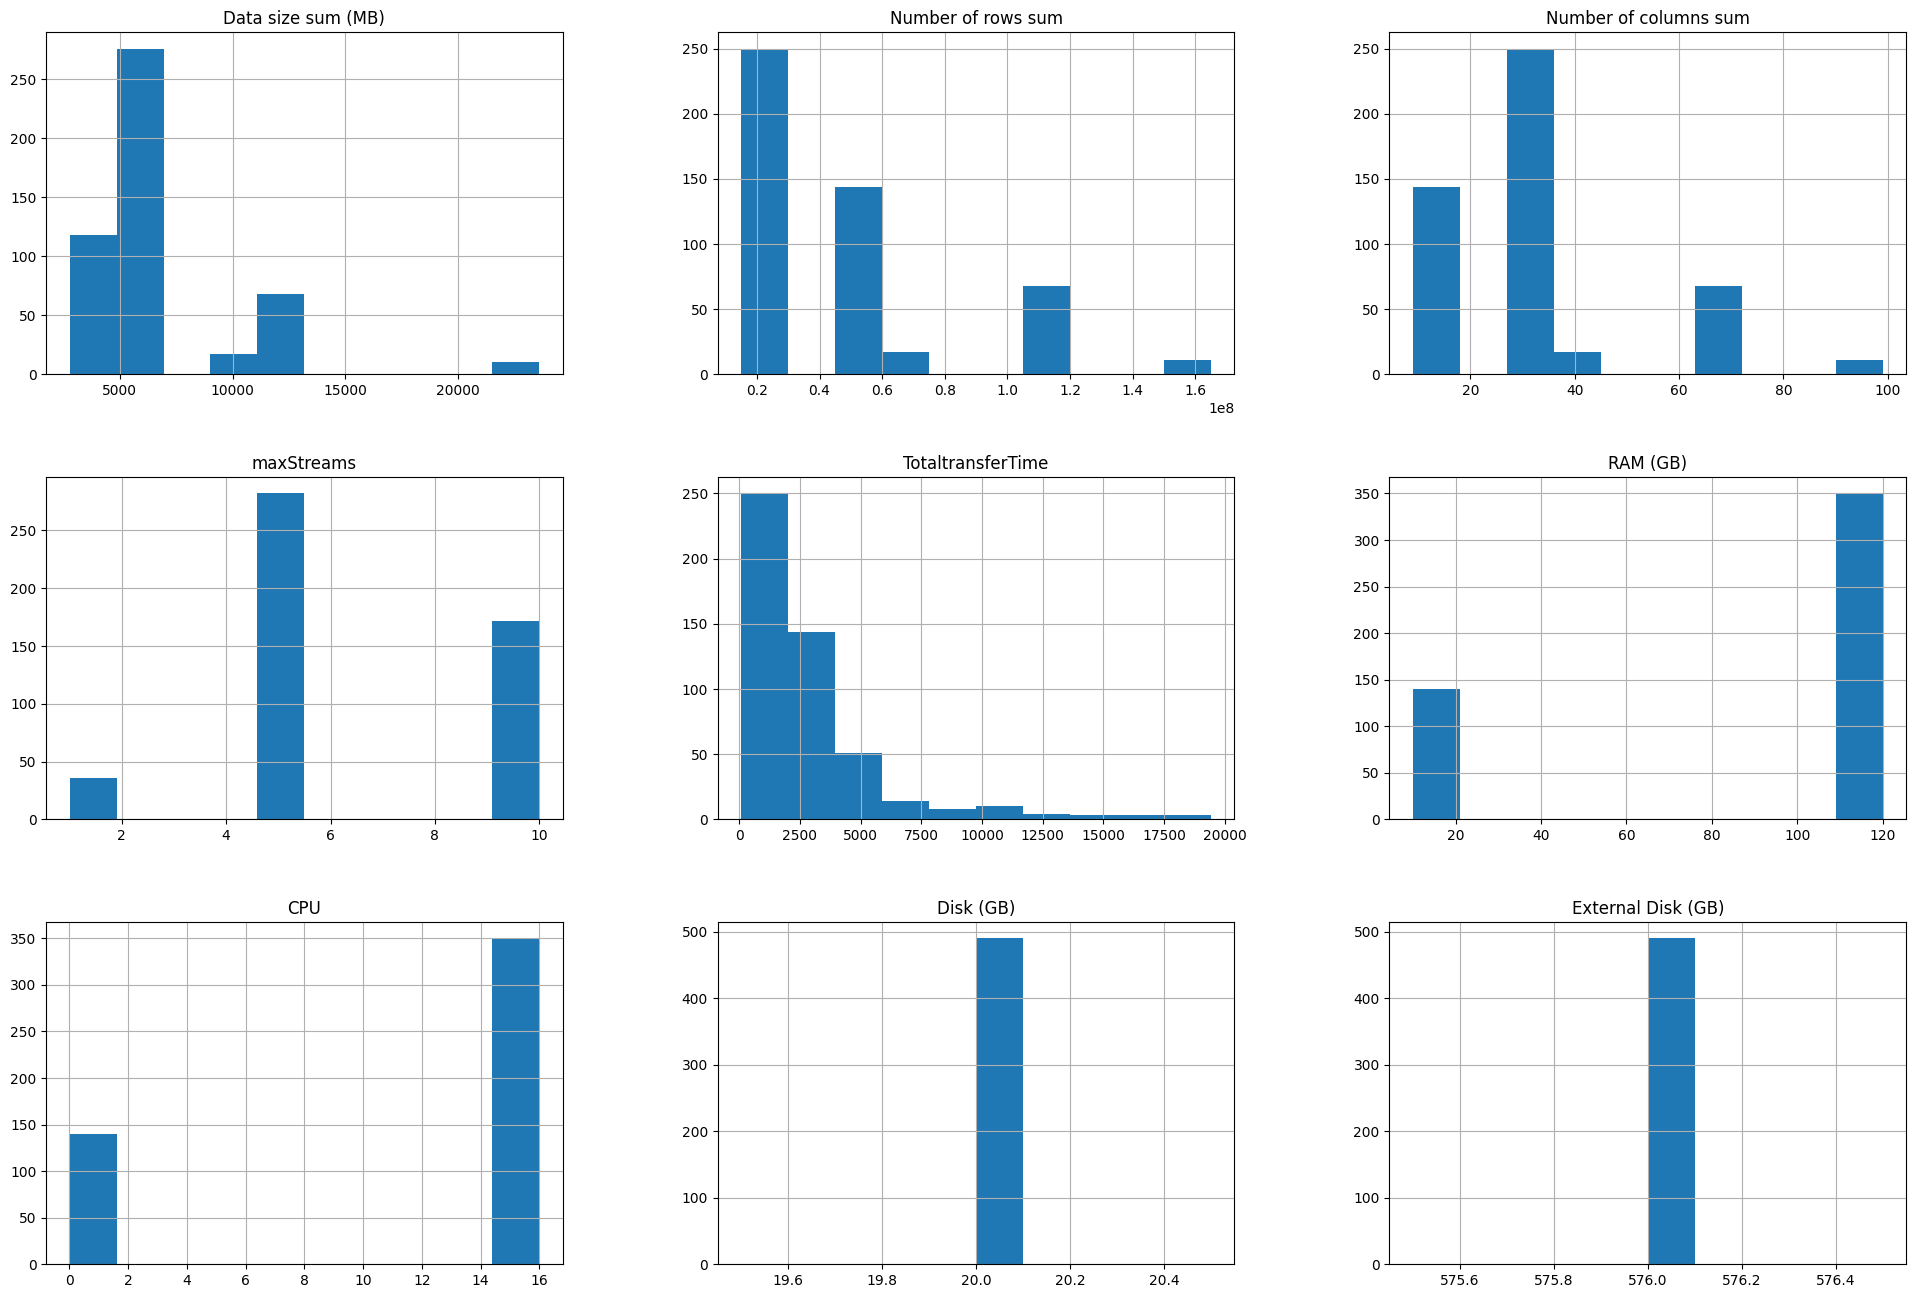

In [59]:
result_df.hist(figsize=(24, 16))
plt.show()

## 5. Preprocessing

### 5.1 Create a pipeline

In [60]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [ ]:
# Separate numerical and categorical columns
num_cols = result_df.select_dtypes(include='number').columns.to_list()
cat_cols = result_df.select_dtypes(exclude='number').columns.to_list()

# Exclude the target from numerical columns
num_cols.remove("TotaltransferTime")

# Create pipelines for numeric and categorical columns
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

# Use ColumnTransformer to set the estimators and transformations
preprocessing = ColumnTransformer([('num', num_pipeline, num_cols),
                                   ('cat', cat_pipeline, cat_cols)],
                                    remainder='passthrough'
                                 )

In [62]:
# Display the pipeline
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Data size sum (MB)', 'Number of rows sum',
                                  'Number of columns sum', 'maxStreams',
                                  'RAM (GB)', 'CPU', 'Disk (GB)',
                                  'External Disk (GB)']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['compress', 'binary'])])

In [63]:
# Apply the preprocessing pipeline on the dataset
result_df_prepared = preprocessing.fit_transform(result_df)

# Scikit-learn strips the column headers, so just add them back on afterward.
feature_names = preprocessing.get_feature_names_out()
result_df_prepared = pd.DataFrame(data=result_df_prepared, columns=feature_names)

result_df_prepared

,num__Data size sum (MB),num__Number of rows sum,num__Number of columns sum,num__maxStreams,num__RAM (GB),num__CPU,num__Disk (GB),num__External Disk (GB),cat__compress_GZIP,cat__compress_LZ4,cat__compress_NO,cat__binary_False,cat__binary_True,remainder__TotaltransferTime
0,-0.886367,-0.626309,0.185133,-0.522672,-1.581139,-1.580910,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1316.606168
1,-0.886367,-0.626309,0.185133,-0.522672,-1.581139,-1.580910,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1047.599877
2,-0.886367,-0.626309,0.185133,-0.522672,-1.581139,-1.580910,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1168.301981
3,-0.886367,-0.626309,0.185133,-0.522672,-1.581139,-1.580910,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1680.701212
4,-0.886367,-0.626309,0.185133,-0.522672,-1.581139,-1.580910,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1097.199158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,-0.258619,-0.795742,-0.167062,-0.522672,0.632456,0.632456,0.0,0.0,0.0,0.0,1.0,1.0,0.0,563.725937
486,-0.258619,-0.795742,-0.167062,-0.522672,0.632456,0.632456,0.0,0.0,0.0,0.0,1.0,1.0,0.0,907.880295
487,-0.258619,-0.795742,-0.167062,-0.522672,0.632456,0.632456,0.0,0.0,0.0,0.0,1.0,1.0,0.0,550.628901
488,-0.258619,-0.795742,-0.167062,-0.522672,0.632456,0.632456,0.0,0.0,0.0,0.0,1.0,1.0,0.0,523.224117


## 6. Model Selection and Training

### 6.1 Split the dataset into a training dataset (80%) and testing dataset (20%).

In [64]:
from sklearn.model_selection import train_test_split

# Splitting data into features and target variable
X = result_df_prepared.drop(["remainder__TotaltransferTime"], axis=1)
y = result_df_prepared["remainder__TotaltransferTime"]

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(392, 13) (392,) (98, 13) (98,)


In [65]:
# Dictionary to store the reports
reports = {}
feature_importances = {}
default_models_df = {}

In [66]:
# Decision Tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor

### 6.2 Statistical Validation 

Cross Validation Over K Folds for Models with Default Parameters

In [95]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import xgboost as xgb
import numpy as np
import pandas as pd

# Define a function to calculate RMSE as a scoring metric
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Custom scorer for RMSE
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# List of models to evaluate
models = {
    "Decision Tree (Default)": DecisionTreeRegressor(random_state=42),
    "Random Forest (Default)": RandomForestRegressor(random_state=42),
    "Gradient Boosting (Default)": GradientBoostingRegressor(random_state=42),
    "XGBoost (Default)": xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    "Linear Regression (Default)": LinearRegression()
}

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a dictionary to store the RMSE values for each model across all folds
cv_rmse_dict = {}
results_summary = []

# Cross-validate each model and calculate mean and std RMSE
for name, model in models.items():
    # Perform cross-validation with RMSE as scoring and store all fold scores
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)
    cv_rmse_dict[name] = -cv_scores  # Store as positive RMSE values

    # Calculate mean and std RMSE for reporting
    mean_rmse = -np.mean(cv_scores)  # Take negative because cross_val_score returns neg RMSE
    std_rmse = np.std(cv_scores)

    # Convert RMSE from seconds to minutes
    mean_rmse_minutes = mean_rmse / 60
    std_rmse_minutes = std_rmse / 60

    # Store results in a summary list
    results_summary.append({
        "Model": name,
        "Mean RMSE (minutes)": mean_rmse_minutes,
        "STD RMSE (minutes)": std_rmse_minutes
    })

# Create a DataFrame from the summary list
results_df = pd.DataFrame(results_summary)

# Convert results to a DataFrame for easy viewing of fold RMSE
folds_df = pd.DataFrame(cv_rmse_dict).T
folds_df.columns = [f"Fold {i+1}" for i in range(kf.get_n_splits())]

# Display the results
print("Mean and STD RMSE Results:")
print(results_df)
print("\nCross-Validation RMSE for Each Fold:")
print(folds_df)


Mean and STD RMSE Results:
                         Model  Mean RMSE (minutes)  STD RMSE (minutes)
0      Decision Tree (Default)            27.495738            4.931410
1      Random Forest (Default)            27.779305            5.124949
2  Gradient Boosting (Default)            27.544752            5.203375
3            XGBoost (Default)            27.333969            4.987263
4  Linear Regression (Default)            35.005206            6.612138

Cross-Validation RMSE for Each Fold:
                                 Fold 1      Fold 2      Fold 3      Fold 4  \
Decision Tree (Default)     1566.413302 1323.526724 2069.839499 1916.354010   
Random Forest (Default)     1597.649789 1313.236221 2127.088202 1903.255190   
Gradient Boosting (Default) 1540.941228 1286.785718 2108.370124 1921.630334   
XGBoost (Default)           1517.885518 1323.524651 2069.839776 1916.352186   
Linear Regression (Default) 2179.640001 1552.469940 2774.420294 2047.449386   

                            

C:\Users\hasti\AppData\Local\Temp\ipykernel_19764\3848217386.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  feature_corr, pval = spearmanr(X[col], predictions)


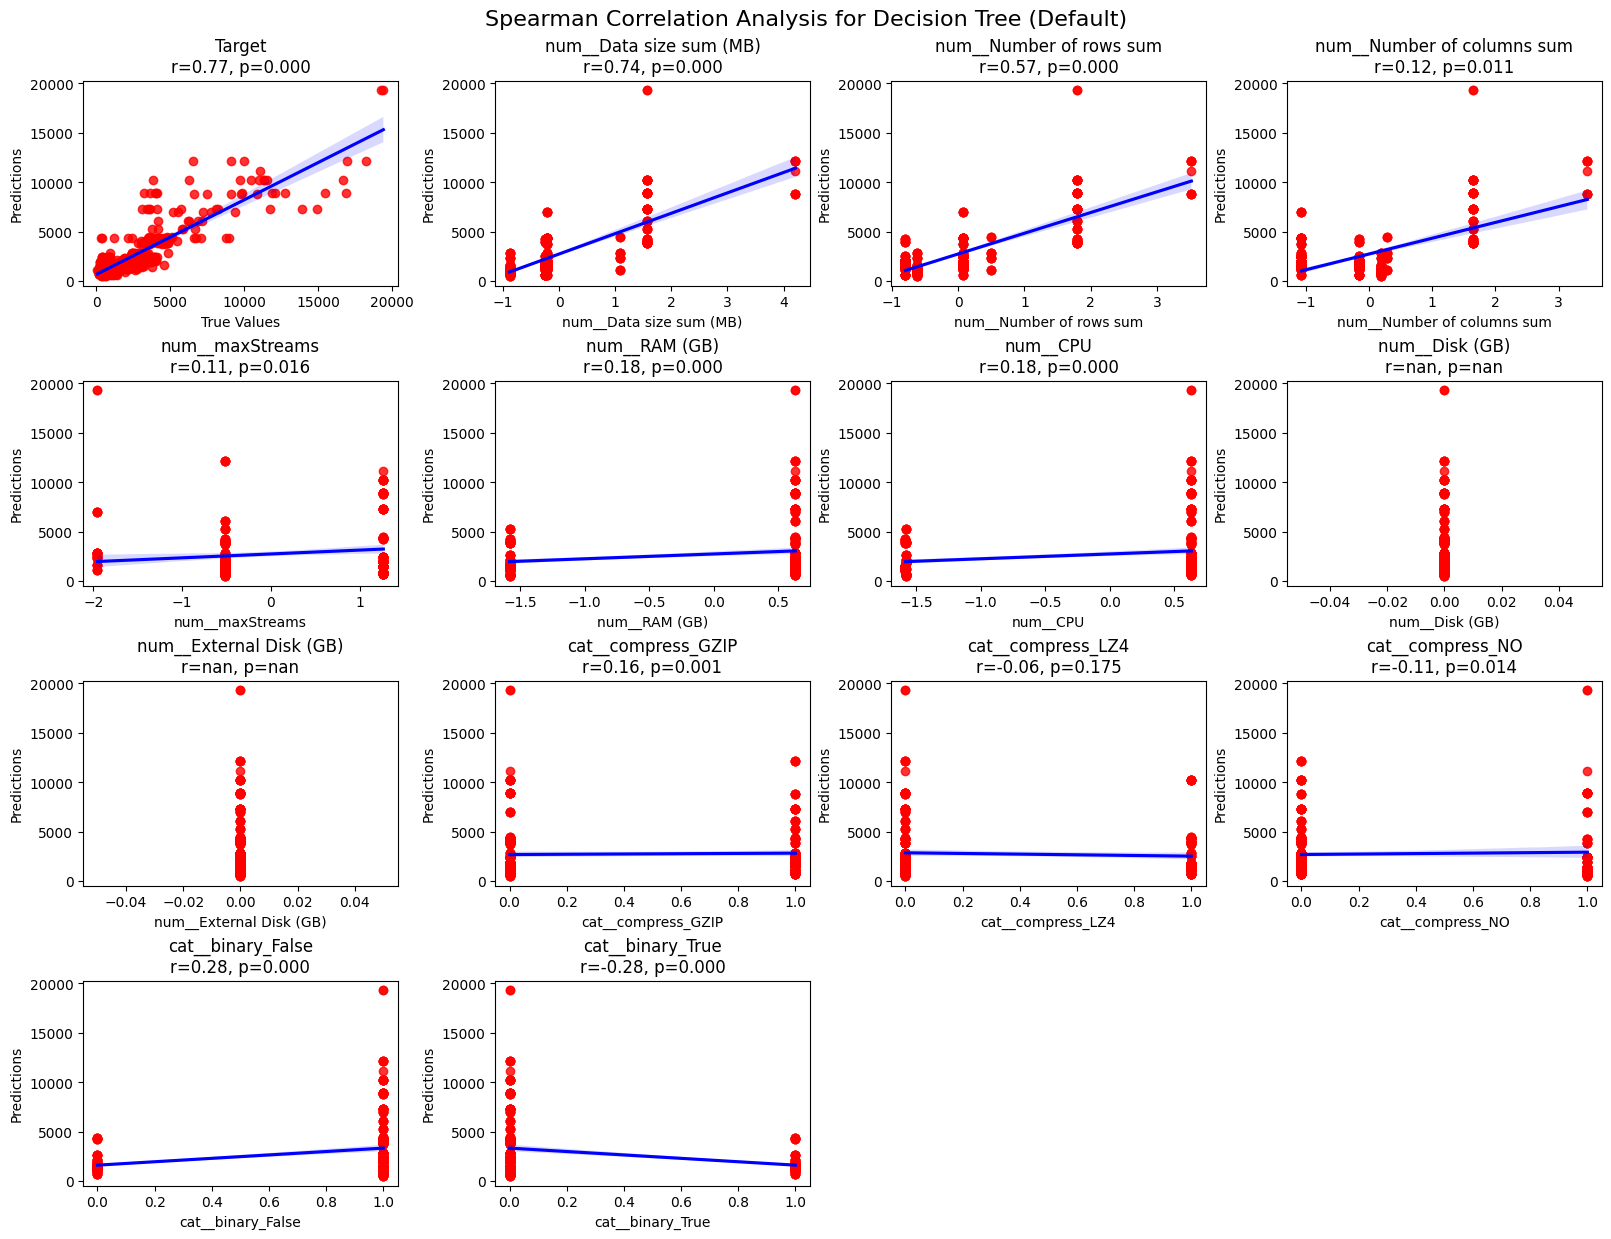

C:\Users\hasti\AppData\Local\Temp\ipykernel_19764\3848217386.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  feature_corr, pval = spearmanr(X[col], predictions)


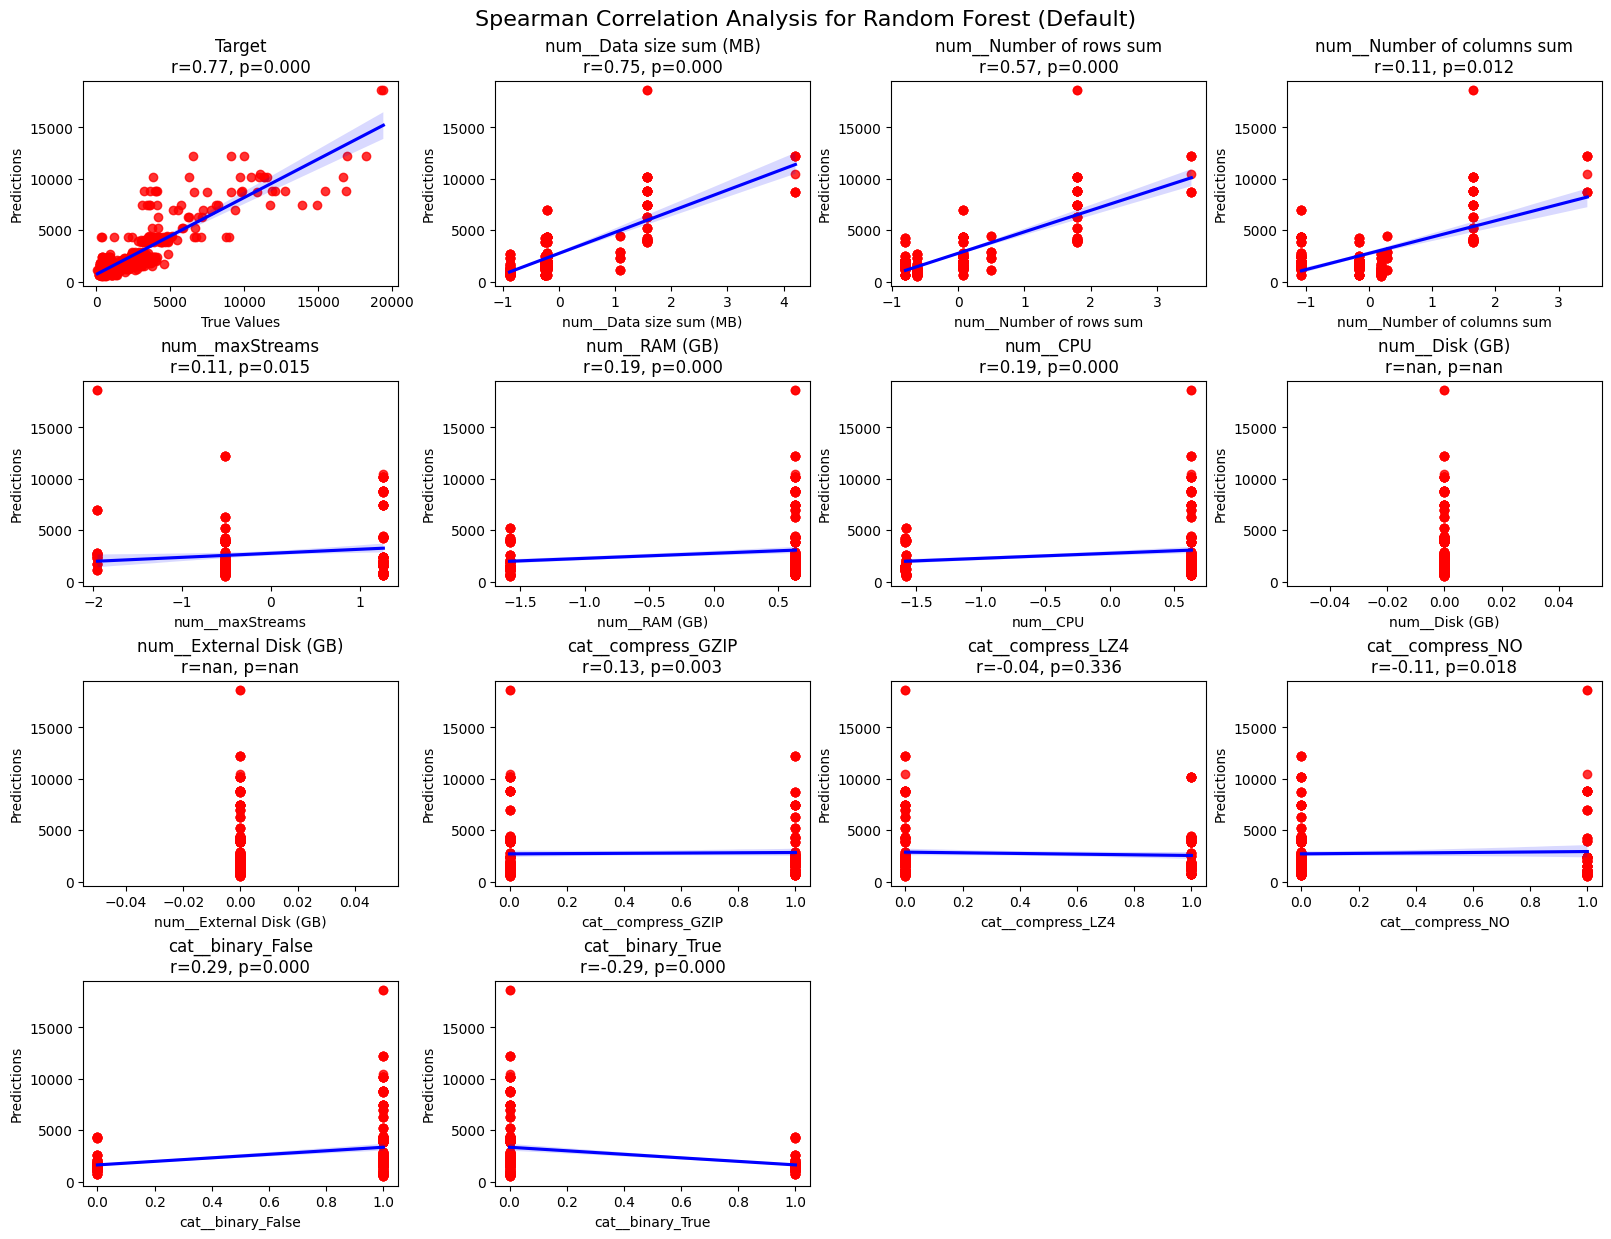

C:\Users\hasti\AppData\Local\Temp\ipykernel_19764\3848217386.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  feature_corr, pval = spearmanr(X[col], predictions)


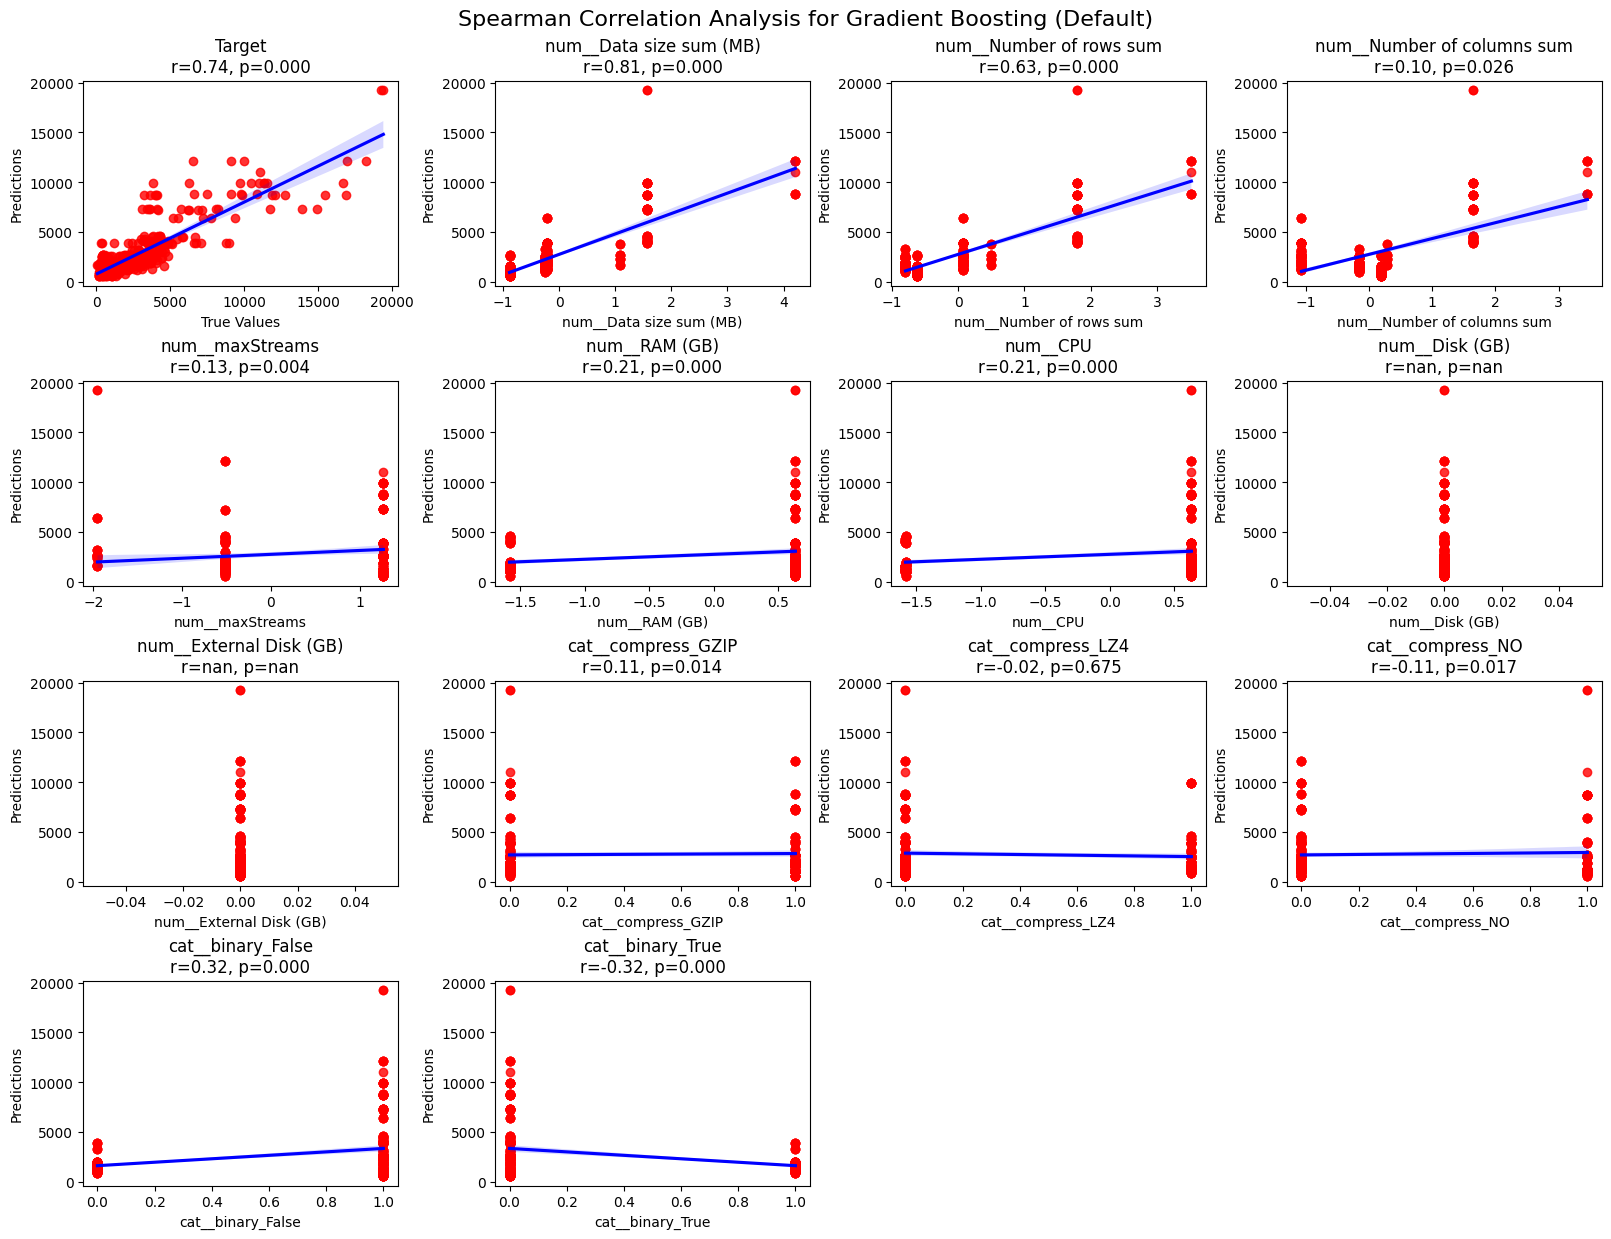

C:\Users\hasti\AppData\Local\Temp\ipykernel_19764\3848217386.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  feature_corr, pval = spearmanr(X[col], predictions)


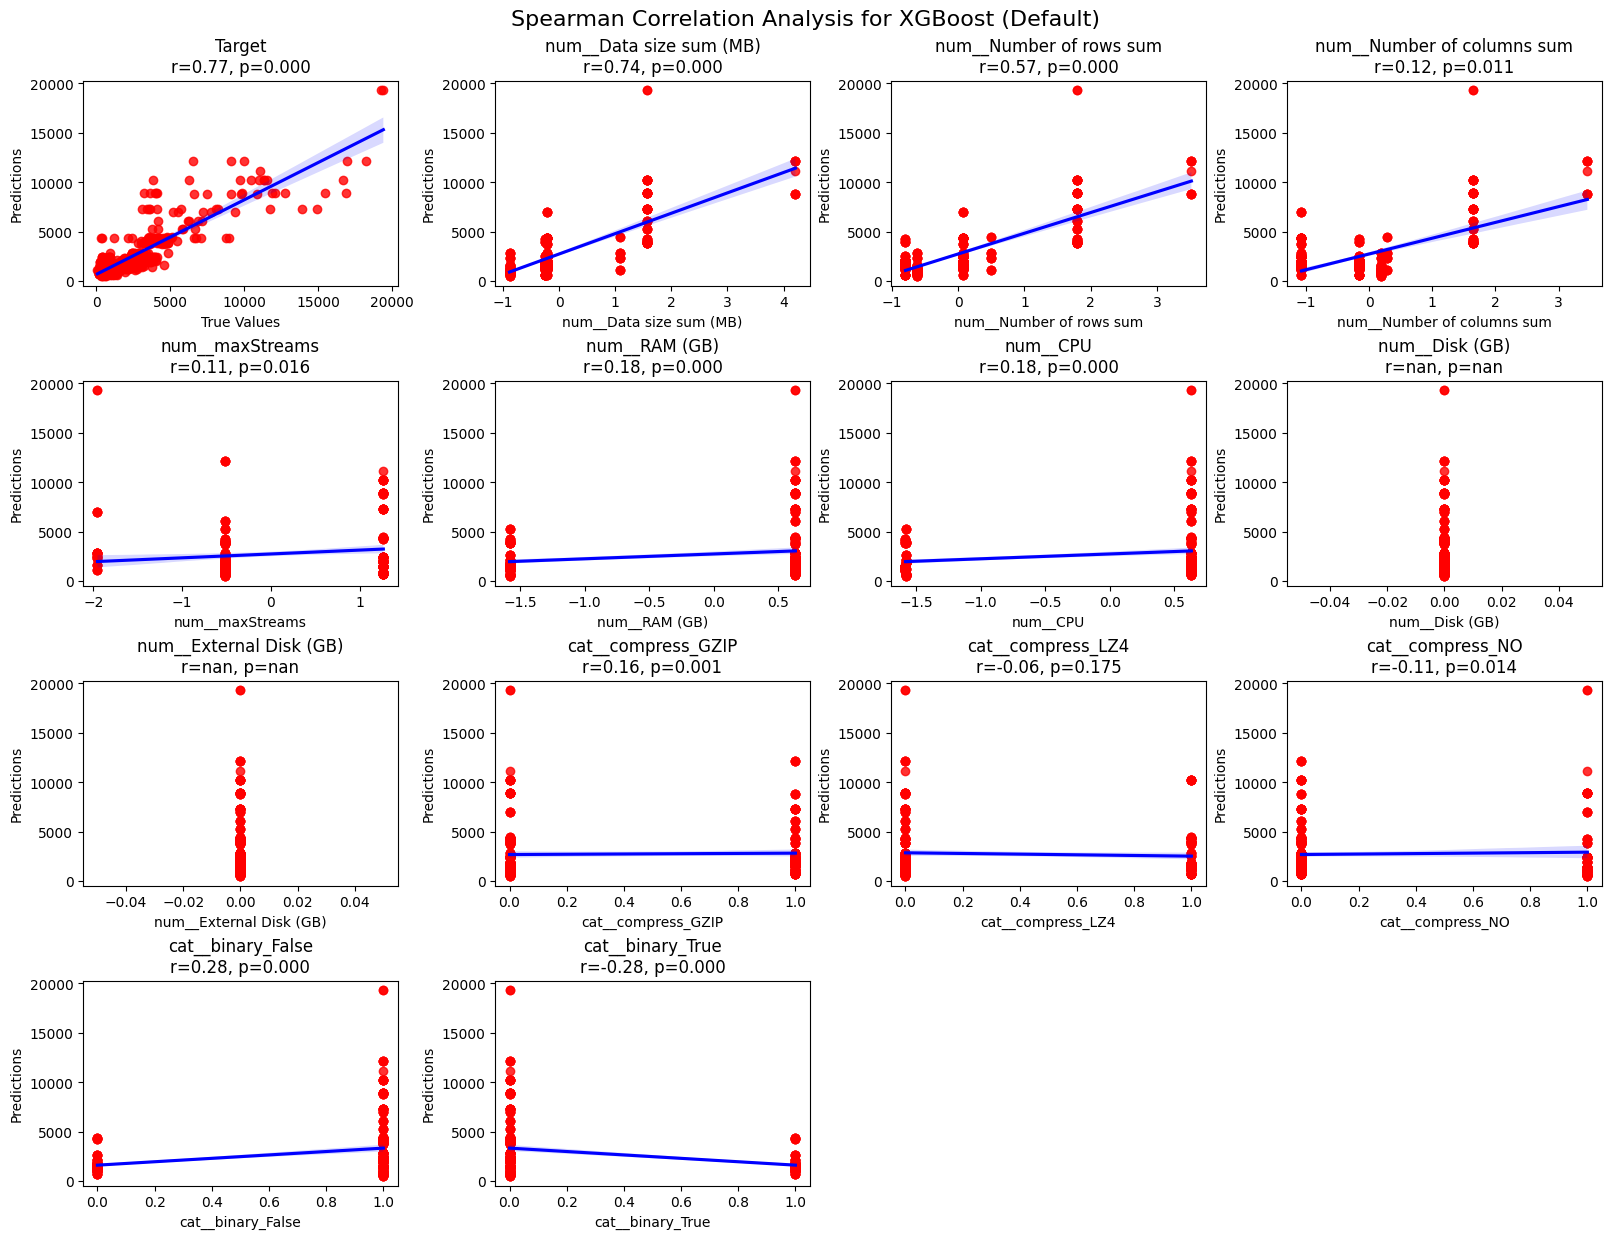

In [94]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
import numpy as np

# Initialize a dictionary to store Spearman correlation results
spearman_results = []

# Analyze each model
for name, model in models.items():
    # Train the model on the entire dataset (for simplicity, assuming no data leakage)
    model.fit(X, y)

    # Get predictions for the dataset
    predictions = model.predict(X)

    # Calculate Spearman correlation with the target
    spearman_target_corr, target_pval = spearmanr(y, predictions)

    # Calculate Spearman correlation with each feature
    feature_correlations = []
    feature_pvals = []
    for col in X.columns:
        feature_corr, pval = spearmanr(X[col], predictions)
        feature_correlations.append(feature_corr)
        feature_pvals.append(pval)

    # Store results
    spearman_results.append({
        "Model": name,
        "Target Correlation": spearman_target_corr,
        "Feature Correlations": feature_correlations,
        "Feature P-Values": feature_pvals
    })

    # Create subplots
    num_features = len(X.columns)
    num_plots = num_features + 1  # Include target correlation
    cols = 4  # Number of columns in the grid
    rows = (num_plots // cols) + (num_plots % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(16, 12), constrained_layout=True)

    # Flatten the axes for easier indexing
    axes = axes.flatten()

    # Plot target correlation
    sns.regplot(
        x=y, y=predictions, ax=axes[0], scatter_kws={"color": "red"}, line_kws={"color": "blue"}
    )
    axes[0].set_title(f"Target\nr={spearman_target_corr:.2f}, p={target_pval:.3f}")
    axes[0].set_xlabel("True Values")
    axes[0].set_ylabel("Predictions")

    # Plot feature correlations
    for i, col in enumerate(X.columns):
        sns.regplot(
            x=X[col], y=predictions, ax=axes[i + 1], scatter_kws={"color": "red"}, line_kws={"color": "blue"}
        )
        axes[i + 1].set_title(
            f"{col}\nr={feature_correlations[i]:.2f}, p={feature_pvals[i]:.3f}"
        )
        axes[i + 1].set_xlabel(col)
        axes[i + 1].set_ylabel("Predictions")

    # Turn off unused subplots
    for j in range(num_plots, len(axes)):
        axes[j].axis("off")

    # Add a main title for the entire grid
    fig.suptitle(f"Spearman Correlation Analysis for {name}", fontsize=16, y=1.02)

    # Show the plot
    plt.show()


Shapiro-Wilk test:

In [96]:
from scipy.stats import shapiro


# Run Shapiro-Wilk test for each model's RMSE values
for model_name, rmse_values in cv_rmse_dict.items():
    stat, p_value = shapiro(rmse_values)
    print(f"{model_name}: Shapiro-Wilk test statistic = {stat:.4f}, p-value = {p_value:.4f}")
    
    if p_value > 0.05:
        print(f"The RMSE values for {model_name} are approximately normally distributed.")
    else:
        print(f"The RMSE values for {model_name} are not normally distributed.")


Decision Tree (Default): Shapiro-Wilk test statistic = 0.8989, p-value = 0.4037
The RMSE values for Decision Tree (Default) are approximately normally distributed.
Random Forest (Default): Shapiro-Wilk test statistic = 0.9331, p-value = 0.6175
The RMSE values for Random Forest (Default) are approximately normally distributed.
Gradient Boosting (Default): Shapiro-Wilk test statistic = 0.9227, p-value = 0.5475
The RMSE values for Gradient Boosting (Default) are approximately normally distributed.
XGBoost (Default): Shapiro-Wilk test statistic = 0.8789, p-value = 0.3041
The RMSE values for XGBoost (Default) are approximately normally distributed.
Linear Regression (Default): Shapiro-Wilk test statistic = 0.9577, p-value = 0.7922
The RMSE values for Linear Regression (Default) are approximately normally distributed.


Levene's Test

In [97]:
import pandas as pd
from scipy.stats import levene


# Run Levene's test to compare the variances
stat, p_value = levene(*[folds_df[model] for model in folds_df.columns])

# Output the results
print("\nLevene's Test Results:")
print(f"Statistic: {stat:.4f}, p-value: {p_value:.4f}")

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: The variances are significantly different.")
else:
    print("Fail to reject the null hypothesis: The variances are not significantly different.")



Levene's Test Results:
Statistic: 0.3366, p-value: 0.8501
Fail to reject the null hypothesis: The variances are not significantly different.


ANOVA Test

In [98]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# Extract RMSE values for each model from cv_rmse_dict
rmse_values = [rmse for rmse in cv_rmse_dict.values()]
model_names = list(cv_rmse_dict.keys())

# Perform One-Way ANOVA
anova_stat, anova_p_value = f_oneway(*rmse_values)
print(f"ANOVA test statistic: {anova_stat:.4f}, p-value: {anova_p_value:.4f}")

if anova_p_value < 0.05:
    print("There is a statistically significant difference between models' RMSEs.")
    
    # Prepare data for Tukey's HSD
    # Flatten the list of RMSE values and create a corresponding list of model labels
    rmse_flat = [item for sublist in rmse_values for item in sublist]
    model_labels = sum([[name] * len(cv_rmse_dict[name]) for name in model_names], [])

    # Perform Tukey's HSD test
    tukey_result = pairwise_tukeyhsd(endog=rmse_flat, groups=model_labels, alpha=0.05)
    print("\nTukey's HSD Test Results:")
    print(tukey_result)
else:
    print("No statistically significant difference between models' RMSEs.")


ANOVA test statistic: 1.5283, p-value: 0.2320
No statistically significant difference between models' RMSEs.


Default Models Performance Report

In [100]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

# Define custom scoring functions for each metric
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

# Custom scorers for each metric
rmse_scorer = make_scorer(rmse, greater_is_better=False)
mae_scorer = make_scorer(mae, greater_is_better=False)
r2_scorer = make_scorer(r2)

# List of models to evaluate
models = {
    "Decision Tree (Default)": DecisionTreeRegressor(random_state=42),
    "Random Forest (Default)": RandomForestRegressor(random_state=42),
    "Gradient Boosting (Default)": GradientBoostingRegressor(random_state=42),
    "XGBoost (Default)": xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    "Linear Regression (Default)": LinearRegression()
}

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a dictionary to store metrics for each model
cv_results = {metric: {} for metric in ["RMSE", "MAE", "MSE", "R2"]}

# Evaluate each model across each metric
for name, model in models.items():
    # Compute cross-validated scores for each metric
    rmse_scores = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)
    mae_scores = cross_val_score(model, X, y, cv=kf, scoring=mae_scorer)
    mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')  # Use negative MSE
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring=r2_scorer)
    
    # Store mean and standard deviation of each metric (convert MSE to positive)
    cv_results["RMSE"][name] = {"Mean": -np.mean(rmse_scores) / 60, "STD": np.std(rmse_scores) / 60}  # Convert to minutes
    cv_results["MAE"][name] = {"Mean": -np.mean(mae_scores) / 60, "STD": np.std(mae_scores) / 60}      # Convert to minutes
    cv_results["MSE"][name] = {"Mean": -np.mean(mse_scores) / 60, "STD": np.std(mse_scores) / 60}      # Convert to minutes
    cv_results["R2"][name] = {"Mean": np.mean(r2_scores), "STD": np.std(r2_scores)}

# Convert results to DataFrames for easy comparison
summary_df = pd.DataFrame({
    "RMSE Mean (min)": [cv_results["RMSE"][name]["Mean"] for name in models.keys()],
    "RMSE STD (min)": [cv_results["RMSE"][name]["STD"] for name in models.keys()],
    "MAE Mean (min)": [cv_results["MAE"][name]["Mean"] for name in models.keys()],
    "MAE STD (min)": [cv_results["MAE"][name]["STD"] for name in models.keys()],
    "MSE Mean (min)": [cv_results["MSE"][name]["Mean"] for name in models.keys()],
    "MSE STD (min)": [cv_results["MSE"][name]["STD"] for name in models.keys()],
    "R2 Mean": [cv_results["R2"][name]["Mean"] for name in models.keys()],
    "R2 STD": [cv_results["R2"][name]["STD"] for name in models.keys()]
}, index=models.keys())

# Print summary of results
print("\nSummary of Model Evaluation Results:")
summary_df



Summary of Model Evaluation Results:


,RMSE Mean (min),RMSE STD (min),MAE Mean (min),MAE STD (min),MSE Mean (min),MSE STD (min),R2 Mean,R2 STD
Decision Tree (Default),27.495738,4.931410,17.779216,1.855555,46820.063024,16702.527311,0.676412,0.062532
Random Forest (Default),27.779305,5.124949,18.065405,2.173389,47877.291813,17610.826847,0.671596,0.056042
Gradient Boosting (Default),27.544752,5.203375,18.238355,1.985256,47147.307222,17746.133209,0.676897,0.057170
XGBoost (Default),27.333969,4.987263,17.666729,1.847712,46321.119365,16908.074288,0.679264,0.066748
Linear Regression (Default),35.005206,6.612138,24.376663,2.682725,76145.088051,29082.952218,0.480256,0.082180


Hyperparameter Tuning

In [73]:
# Function to generate regression reports
def regression_report(model, X_train, y_train):
    # Split X_train and y_train to create a validation set
    X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    # Train on the train part
    model.fit(X_train_part, y_train_part)
    
    # Predict on the validation set
    y_pred = model.predict(X_val)
    
    # Calculate metrics
    mae = mean_absolute_error(y_val, y_pred)  # Mean Absolute Error
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))  # Root Mean Squared Error
    r2 = r2_score(y_val, y_pred)  # R² Score

    return mae, rmse_val, r2  # Return only MAE, RMSE, and R²

In [74]:
# Define feature importance function
def plot_feature_importance(model, X, title):
    # Plot feature importance
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]
    features = np.array(X.columns)
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(X.shape[1]), importance[indices], align='center')
    plt.xticks(range(X.shape[1]), features[indices], rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.tight_layout()
    plt.show()

In [75]:
# Initialize a dictionary to store reports and RMSE scores
reports = {}
metrics_scores = {}

### 6.3 Two Top Models Training and Hyperparameter Tuning

In [76]:
# Decision Tree Default Model
default_dt_model = DecisionTreeRegressor(random_state=42)
reports["Decision Tree (Default)"] = regression_report(default_dt_model, X_train, y_train)
metrics_scores["Decision Tree (Default)"] = reports["Decision Tree (Default)"]

# Hyperparameter tuning for Decision Tree
param_dist_dt = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

random_search_dt = RandomizedSearchCV(DecisionTreeRegressor(random_state=42), 
                                      param_distributions=param_dist_dt, 
                                      n_iter=100, cv=5, random_state=42)
random_search_dt.fit(X_train, y_train)
best_dt_model_random = random_search_dt.best_estimator_

# Report for Random Search Decision Tree
reports["Decision Tree (Random Search)"] = regression_report(best_dt_model_random, X_train, y_train)
metrics_scores["Decision Tree (Random Search)"] = reports["Decision Tree (Random Search)"]

# Grid Search for Decision Tree
param_grid_dt = {
    'max_depth': [1, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15]
}

grid_search_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), 
                              param_grid=param_grid_dt, 
                              cv=5, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)
best_dt_model_grid = grid_search_dt.best_estimator_

# Report for Grid Search Decision Tree
reports["Decision Tree (Grid Search)"] = regression_report(best_dt_model_grid, X_train, y_train)
metrics_scores["Decision Tree (Grid Search)"] = reports["Decision Tree (Grid Search)"]


In [77]:
# XGBoost Default Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
best_model = xgb_model.fit(X_train, y_train)
reports["XGBoost (Default)"] = regression_report(xgb_model, X_train, y_train)
metrics_scores["XGBoost (Default)"] = reports["XGBoost (Default)"]

# Hyperparameter tuning for XGBoost
param_dist_xgb = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

random_search_xgb = RandomizedSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42), 
                                       param_distributions=param_dist_xgb,
                                       n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search_xgb.fit(X_train, y_train)
best_xgb_model_random = random_search_xgb.best_estimator_

# Report for Random Search XGBoost
reports["XGBoost (Random Search)"] = regression_report(best_xgb_model_random, X_train, y_train)
metrics_scores["XGBoost (Random Search)"] = reports["XGBoost (Random Search)"]

# Grid Search for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search_xgb = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42), 
                               param_grid=param_grid_xgb, 
                               cv=5, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
best_xgb_model_grid = grid_search_xgb.best_estimator_

# Report for Grid Search XGBoost
reports["XGBoost (Grid Search)"] = regression_report(best_xgb_model_grid, X_train, y_train)
metrics_scores["XGBoost (Grid Search)"] = reports["XGBoost (Grid Search)"]

Exporting the best model (XGBoost Default)

In [78]:
import joblib

# Save the trained XGBoost model
xgb_model.feature_names = list(X_train.columns)
joblib.dump(best_model, 'xgboost_model_default.pkl')
print("Model saved as 'xgboost_model_default.pkl'")


Model saved as 'xgboost_model_default.pkl'


In [ ]:
# DataFrame to consolidate all metrics
metrics_data = {
    'Model': [
        'Decision Tree (Default)',
        'Decision Tree (Random Search)',
        'Decision Tree (Grid Search)',
        'XGBoost (Default)',
        'XGBoost (Random Search)',
        'XGBoost (Grid Search)'
    ],
    'MAE': [
        metrics_scores["Decision Tree (Default)"][0],  # MAE
        metrics_scores["Decision Tree (Random Search)"][0],
        metrics_scores["Decision Tree (Grid Search)"][0],
        metrics_scores["XGBoost (Default)"][0],
        metrics_scores["XGBoost (Random Search)"][0],
        metrics_scores["XGBoost (Grid Search)"][0]
    ],
    'RMSE': [
        metrics_scores["Decision Tree (Default)"][1],  # RMSE
        metrics_scores["Decision Tree (Random Search)"][1],
        metrics_scores["Decision Tree (Grid Search)"][1],
        metrics_scores["XGBoost (Default)"][1],
        metrics_scores["XGBoost (Random Search)"][1],
        metrics_scores["XGBoost (Grid Search)"][1]
    ],
    'R2': [
        metrics_scores["Decision Tree (Default)"][2],
        metrics_scores["Decision Tree (Random Search)"][2],
        metrics_scores["Decision Tree (Grid Search)"][2],
        metrics_scores["XGBoost (Default)"][2],
        metrics_scores["XGBoost (Random Search)"][2],
        metrics_scores["XGBoost (Grid Search)"][2]
    ]
}

# Create the DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Sort by RMSE or any other metric if desired
metrics_df = metrics_df.sort_values(by='RMSE').reset_index(drop=True)

# Display the consolidated metrics DataFrame
print("\nConsolidated Model Metrics:")
print(metrics_df)


Consolidated Model Metrics:
                           Model          MAE         RMSE        R2
0              XGBoost (Default)   893.759956  1443.885031  0.752291
1        Decision Tree (Default)   893.760367  1443.886053  0.752291
2          XGBoost (Grid Search)   887.845719  1459.998713  0.746731
3        XGBoost (Random Search)   934.141496  1543.324850  0.716997
4    Decision Tree (Grid Search)  1104.459381  1660.829674  0.672262
5  Decision Tree (Random Search)  1090.712819  1698.398820  0.657267


In [80]:
# Performance metric in minutes
metrics_df[['MAE', 	'RMSE']] /= 60

metrics_df.sort_values('RMSE')

,Model,MAE,RMSE,R2
0,XGBoost (Default),14.895999,24.064751,0.752291
1,Decision Tree (Default),14.896006,24.064768,0.752291
2,XGBoost (Grid Search),14.797429,24.333312,0.746731
3,XGBoost (Random Search),15.569025,25.722081,0.716997
4,Decision Tree (Grid Search),18.407656,27.680495,0.672262
5,Decision Tree (Random Search),18.178547,28.306647,0.657267


## 7. Visualizing the Performance

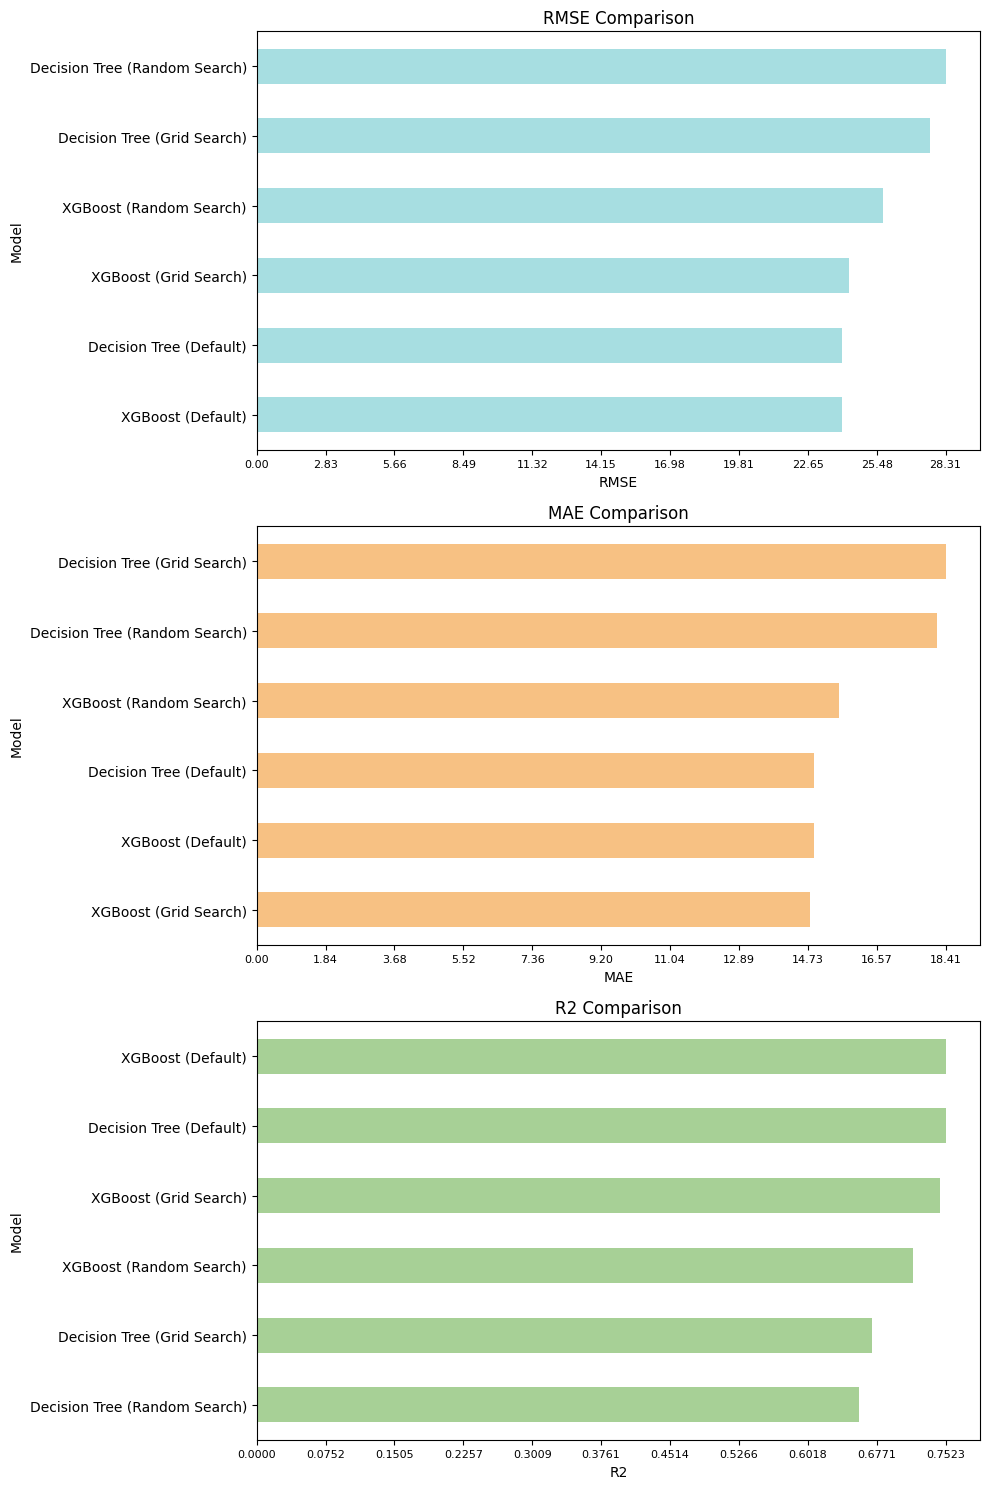

In [81]:

import matplotlib.pyplot as plt

# Define colors for each metric
colors = {
    'RMSE': '#a7dee1',       # RMSE in blue
    'MAE': '#f7c183',       # MAE in green
    'R2': '#a7d096'        # R2 in purple
}

# Define the metrics
metrics = ['RMSE', 'MAE', 'R2']
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=False)

# Loop over each metric and customize each subplot
for i, metric in enumerate(metrics):
    metrics_df.sort_values(by=metric).plot(kind='barh', x='Model', y=metric, ax=axes[i], color=colors[metric], legend=False)
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_xlabel(metric)
    
    # Adjust x-axis to show floating-point numbers
    max_value = metrics_df[metric].max()
    step_size = max_value / 10  # Define a step size relative to the maximum value
    axes[i].set_xticks(np.arange(0, max_value + step_size, step_size))
    axes[i].tick_params(axis='x', which='both', labelsize=8)

plt.tight_layout()
plt.show()


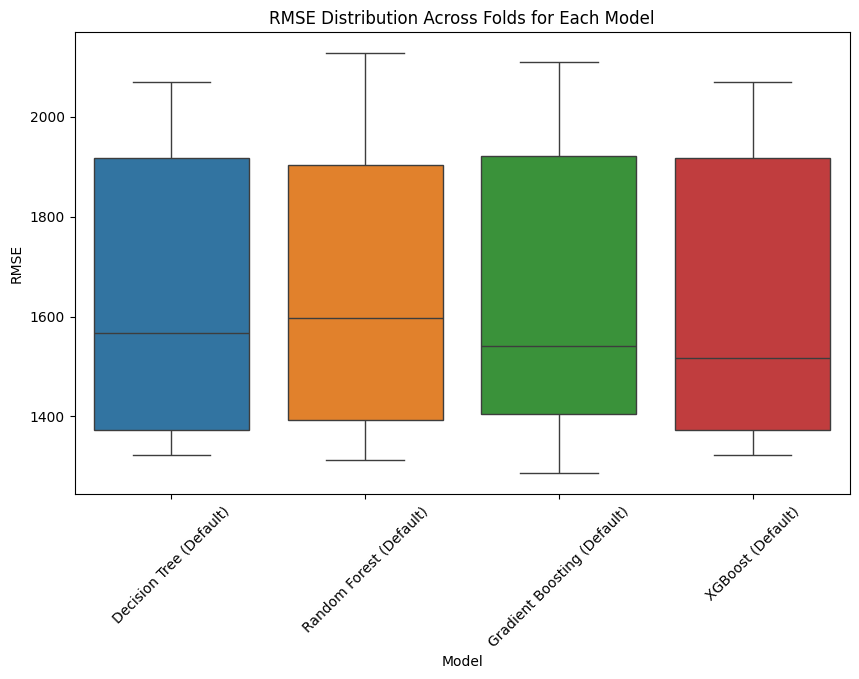

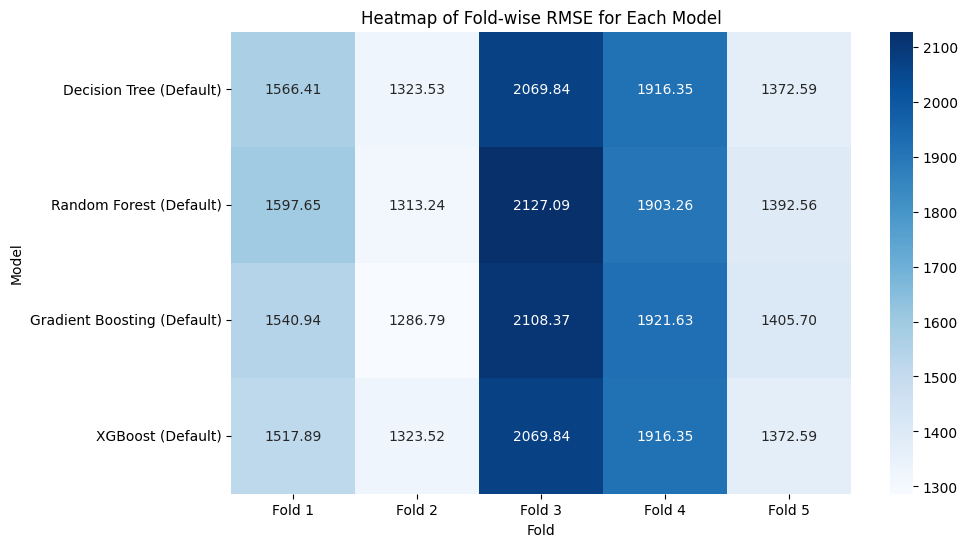

In [82]:

rmse_df = pd.DataFrame(cv_rmse_dict).T  # RMSE values across folds
rmse_df.columns = [f"Fold {i+1}" for i in range(rmse_df.shape[1])]

plt.figure(figsize=(10, 6))
sns.boxplot(data=rmse_df.T)
plt.title('RMSE Distribution Across Folds for Each Model')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(rmse_df, annot=True, cmap='Blues', fmt=".2f")
plt.title('Heatmap of Fold-wise RMSE for Each Model')
plt.xlabel('Fold')
plt.ylabel('Model')
plt.show()



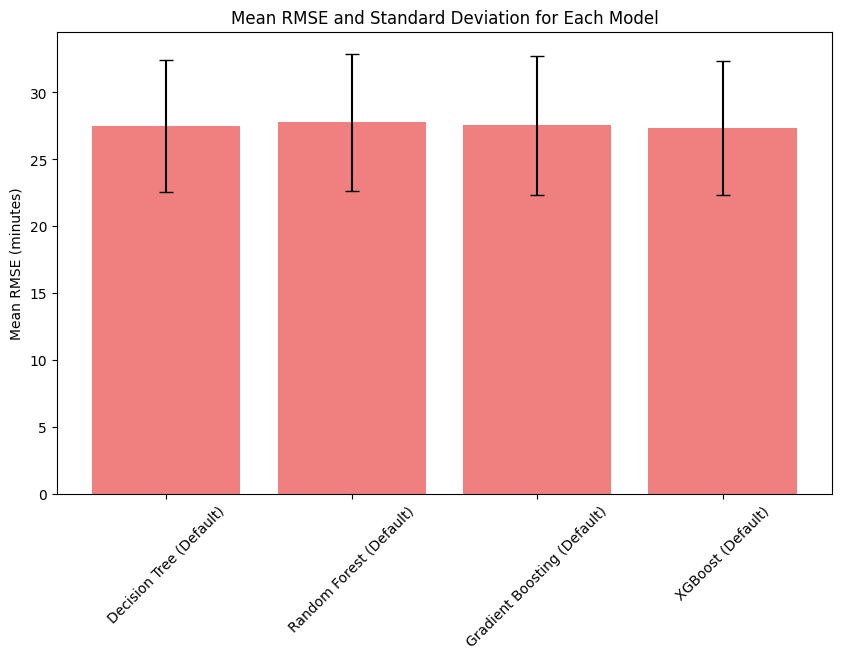

In [83]:
means = [cv_results["RMSE"][model]["Mean"] for model in models.keys()]
stds = [cv_results["RMSE"][model]["STD"] for model in models.keys()]

plt.figure(figsize=(10, 6))
plt.bar(models.keys(), means, yerr=stds, capsize=5, color='lightcoral')
plt.ylabel('Mean RMSE (minutes)')
plt.title('Mean RMSE and Standard Deviation for Each Model')
plt.xticks(rotation=45)
plt.show()


### 7.1 Feature Importances

Visualize the feature importances for each model.


Sorted Feature Importances by Mean Importance:
                       Feature  Decision Tree (Default)  \
0      num__Data size sum (MB)                 0.634816   
1                num__RAM (GB)                 0.130525   
2   num__Number of columns sum                 0.027315   
3      num__Number of rows sum                 0.000000   
4              num__maxStreams                 0.088879   
5            cat__compress_LZ4                 0.034642   
6           cat__compress_GZIP                 0.033547   
7                     num__CPU                 0.025452   
8            cat__binary_False                 0.009113   
9             cat__compress_NO                 0.005279   
10            cat__binary_True                 0.010433   
11              num__Disk (GB)                 0.000000   
12     num__External Disk (GB)                 0.000000   

    Decision Tree (Random Search)  Decision Tree (Grid Search)  \
0                        0.729316                     0.725

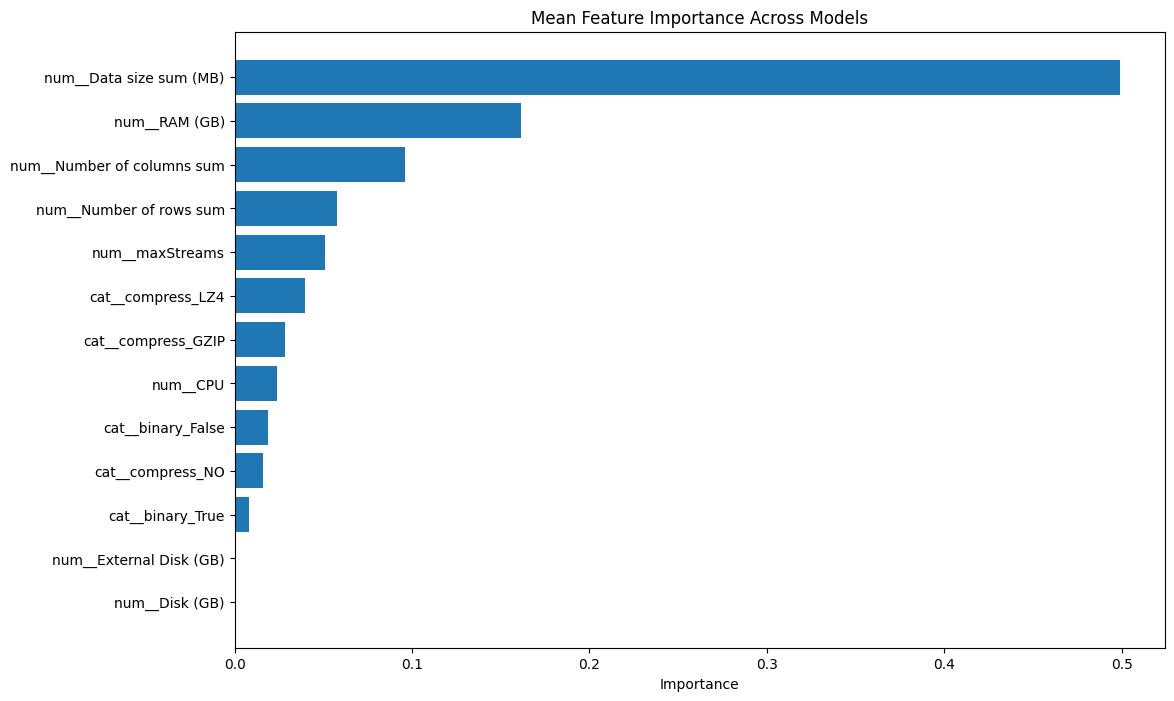

In [84]:
# Initialize a dictionary to store feature importances for all six models
feature_importances = {}

# Add default model feature importances
# Decision Tree Default
feature_importances["Decision Tree (Default)"] = default_dt_model.feature_importances_

# Random and Grid Search Decision Tree
feature_importances["Decision Tree (Random Search)"] = best_dt_model_random.feature_importances_
feature_importances["Decision Tree (Grid Search)"] = best_dt_model_grid.feature_importances_

# XGBoost Default Model
feature_importances["XGBoost (Default)"] = xgb_model.feature_importances_

# Random and Grid Search XGBoost
feature_importances["XGBoost (Random Search)"] = best_xgb_model_random.feature_importances_
feature_importances["XGBoost (Grid Search)"] = best_xgb_model_grid.feature_importances_

# Create a DataFrame to compile feature importances for all models
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Decision Tree (Default)': feature_importances["Decision Tree (Default)"],
    'Decision Tree (Random Search)': feature_importances["Decision Tree (Random Search)"],
    'Decision Tree (Grid Search)': feature_importances["Decision Tree (Grid Search)"],
    'XGBoost (Default)': feature_importances["XGBoost (Default)"],
    'XGBoost (Random Search)': feature_importances["XGBoost (Random Search)"],
    'XGBoost (Grid Search)': feature_importances["XGBoost (Grid Search)"]
}).fillna(0)  # Fill NaN values with 0 for consistency

# Calculate mean importance across all models
importance_df['Mean Importance'] = importance_df.iloc[:, 1:].mean(axis=1)

# Sort by mean importance for easy viewing
importance_df = importance_df.sort_values(by='Mean Importance', ascending=False).reset_index(drop=True)

# Display the sorted DataFrame
print("\nSorted Feature Importances by Mean Importance:")
print(importance_df)

# Plot mean feature importance as a horizontal bar chart
# Calculate the mean feature importance across all models
feature_importances_mean = importance_df.set_index('Feature').mean(axis=1)

# Sort the features by importance
sorted_idx = np.argsort(feature_importances_mean)
sorted_features = feature_importances_mean.index[sorted_idx]
sorted_importances = feature_importances_mean.iloc[sorted_idx]

# Plot the mean feature importances as a horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(sorted_features, sorted_importances, align='center')
ax.set_xlabel('Importance')
ax.set_title('Mean Feature Importance Across Models')
plt.show()


In [85]:
pd.set_option('display.float_format', '{:.6f}'.format)

In [86]:
# Find the index of the model with the maximum RMSE value
max_value_index = metrics_df["RMSE"].idxmin()

# Return the value from the first (unnamed) column in the same row
model_with_max_rmse = metrics_df.iloc[max_value_index, 0]  # First column contains model names

# Print the results
print(f"Model with Maximum RMSE: {model_with_max_rmse}")
print(f"Maximum RMSE Value: {metrics_df['RMSE'].min()}")

Model with Maximum RMSE: XGBoost (Default)
Maximum RMSE Value: 24.06475052174445


In [87]:
# Find the index of the model with the maximum RMSE value
max_value_index = metrics_df["MAE"].idxmin()

# Return the value from the first (unnamed) column in the same row
model_with_max_rmse = metrics_df.iloc[max_value_index, 0]  # First column contains model names

# Print the results
print(f"Model with Maximum MAE: {model_with_max_rmse}")
print(f"Maximum RMSE MAE: {metrics_df['MAE'].min()}")

Model with Maximum MAE: XGBoost (Grid Search)
Maximum RMSE MAE: 14.797428654467506


In [88]:
# Find the index of the model with the maximum RMSE value
max_value_index = metrics_df["R2"].idxmax()

# Return the value from the first (unnamed) column in the same row
model_with_max_rmse = metrics_df.iloc[max_value_index, 0]  # First column contains model names

# Print the results
print(f"Model with Maximum R2: {model_with_max_rmse}")
print(f"Maximum R2 Value: {metrics_df['R2'].max()}")

Model with Maximum R2: XGBoost (Default)
Maximum R2 Value: 0.7522910912095038


c:\Users\hasti\anaconda3\envs\DMBenchML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Analyzing SHAP values for Decision Tree (Best Performing)
SHAP Summary Plot for Decision Tree (Best Performing)


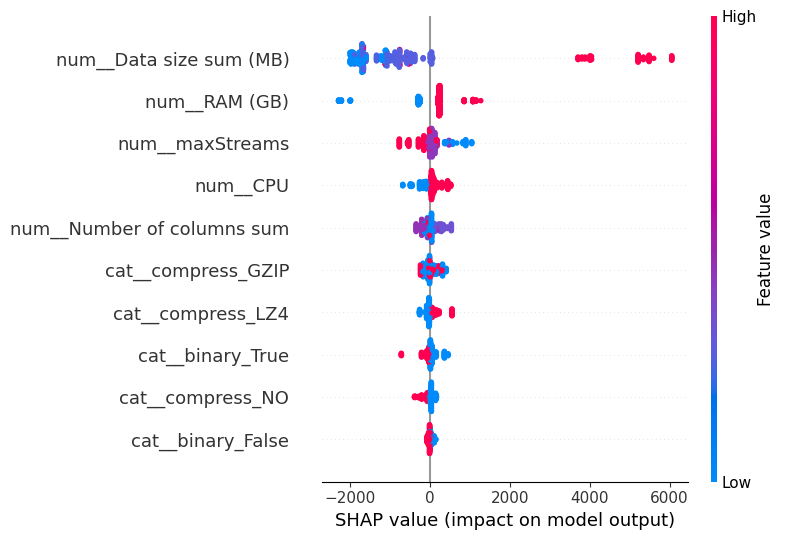

Analyzing SHAP values for XGBoost (Best Performing)
SHAP Summary Plot for XGBoost (Best Performing)


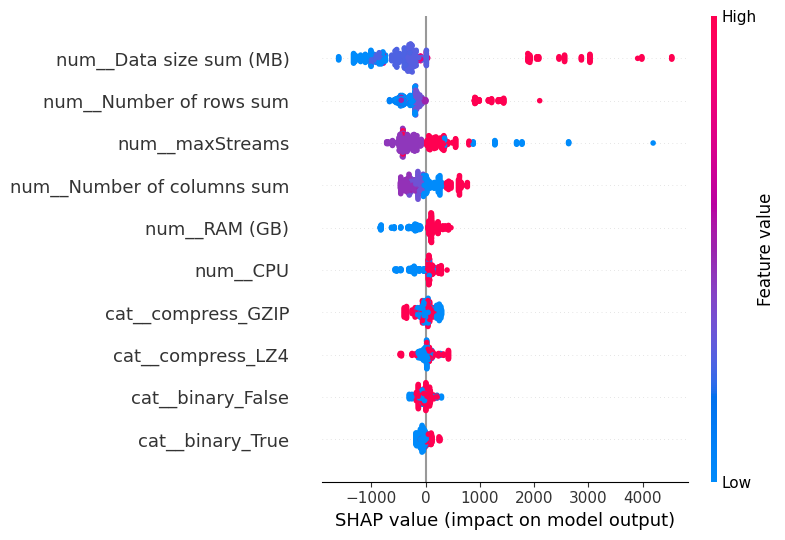

In [89]:
# Import SHAP
import shap

# Function to generate SHAP explainer for a given model
def generate_shap_explainer(model, X_train):
    # Initialize SHAP explainer
    explainer = shap.Explainer(model, X_train)
    # Calculate SHAP values
    shap_values = explainer(X_train)
    
    return explainer, shap_values

# Create a function to plot SHAP values for a model
def plot_shap_summary(model_name, shap_values, X_train, max_display=10):
    print(f"SHAP Summary Plot for {model_name}")
    shap.summary_plot(shap_values, X_train, max_display=max_display)

# Function to generate and display SHAP results for the best model
def analyze_model_shap(model_name, model, X_train):
    explainer, shap_values = generate_shap_explainer(model, X_train)
    plot_shap_summary(model_name, shap_values, X_train)

# Analyze SHAP values for the best Decision Tree and XGBoost models

# Best Decision Tree model (e.g., from Grid Search or Random Search based on lowest RMSE)
print("Analyzing SHAP values for Decision Tree (Best Performing)")
analyze_model_shap("Decision Tree (Best Performing)", best_dt_model_grid, X_train)

# Best XGBoost model (e.g., from Grid Search or Random Search based on lowest RMSE)
print("Analyzing SHAP values for XGBoost (Best Performing)")
analyze_model_shap("XGBoost (Best Performing)", best_xgb_model_grid, X_train)


## 8. Evaluation 

### Final Evaluation of the Bst model XGBoost

In [90]:
# Original DataFrame data
data = {
    'compress': ['LZ4'] * 24,
    'Data size sum (MB)': [2774] * 6 + [5477] * 4 + [2774] * 8 + [5337] * 6,
    'Number of rows sum': [20887909] * 6 + [45000000] * 4 + [20887909] * 8 + [15000000] * 6,
    'Number of columns sum': [34] * 6 + [9] * 4 + [34] * 8 + [27] * 6,
    'maxStreams': [5] * 24,
    'binary': [False] * 24,
    'TotaltransferTime': [
        6614.089232, 10539.955298, 8799.406026, 9924.048079, 9702.185297, 9266.211862,
        28711.608555, 30522.033113, 28353.734039, 18800.444881,
        5880.783306, 5440.685482, 5329.653282, 5602.730134, 6036.759305, 10718.281318,
        5908.693942, 5708.062168, 9903.636934, 10298.397998, 11546.651499, 9009.964056,
        10582.184759, 7494.603194
    ],
    'RAM (GB)': [10.0] * 24,
    'CPU': [0.625] * 10 + [0.0625] * 14,
    'Disk (GB)': [20] * 24,
    'External Disk (GB)': [576] * 24
}
# data = {
#     "compress": ["LZ4"] * 20,
#     "Data size sum (MB)": [2774] * 6 + [5477] * 4 + [5337] * 8 + [5477] * 2,
#     "Number of rows sum": [20887909] * 6 + [45000000] * 4 + [15000000] * 8 + [45000000] * 2,
#     "Number of columns sum": [34] * 6 + [9] * 4 + [27] * 8 + [9] * 2,
#     "maxStreams": [5] * 20,
#     "binary": [False] * 20,
#     "TotaltransferTime": [
#         6614.089232, 10539.955298, 8799.406026, 9924.048079, 9702.185297,
#         9266.211862, 28711.608555, 30522.033113, 28353.734039, 18800.444881,
#         30023.287787, 27507.481905, 18424.489691, 27140.605947, 9182.992406,
#         17665.691685, 16209.207946, 18383.552018, 18029.531206, 15530.392621
#     ],
#     "RAM (GB)": [10.0] * 20,
#     "CPU": [0.625] * 20,
#     "Disk (GB)": [20] * 20,
#     "External Disk (GB)": [576] * 20
# }


# Creating the DataFrame
test_df = pd.DataFrame(data)

In [91]:
test_df

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,LZ4,2774,20887909,34,5,False,6614.089232,10.000000,0.625000,20,576
1,LZ4,2774,20887909,34,5,False,10539.955298,10.000000,0.625000,20,576
2,LZ4,2774,20887909,34,5,False,8799.406026,10.000000,0.625000,20,576
3,LZ4,2774,20887909,34,5,False,9924.048079,10.000000,0.625000,20,576
4,LZ4,2774,20887909,34,5,False,9702.185297,10.000000,0.625000,20,576
5,LZ4,2774,20887909,34,5,False,9266.211862,10.000000,0.625000,20,576
6,LZ4,5477,45000000,9,5,False,28711.608555,10.000000,0.625000,20,576
7,LZ4,5477,45000000,9,5,False,30522.033113,10.000000,0.625000,20,576
8,LZ4,5477,45000000,9,5,False,28353.734039,10.000000,0.625000,20,576
9,LZ4,5477,45000000,9,5,False,18800.444881,10.000000,0.625000,20,576


In [92]:
# Ensure the final DataFrame has the correct column order for the model
required_order = [
    'num__Data size sum (MB)', 'num__Number of rows sum', 'num__Number of columns sum', 
    'num__maxStreams', 'num__RAM (GB)', 'num__CPU', 'num__Disk (GB)', 'num__External Disk (GB)',
    'cat__compress_GZIP', 'cat__compress_LZ4', 'cat__compress_NO',
    'cat__binary_False', 'cat__binary_True', 'remainder__TotaltransferTime'
]

# Convert X_test to a DataFrame and reorder columns to match the model’s expectations
X_test_df = pd.DataFrame(X_test, columns=X.columns)  # Use original X columns here
X_test_ordered = X_test_df.reindex(columns=required_order, fill_value=0)  # Fill missing columns with 0

# Separate features and target in test set
final_X_test = X_test_ordered.drop(["remainder__TotaltransferTime"], axis=1)
final_y_test = y_test  # y_test is already separated as the target

# Run predictions
final_predictions = best_model.predict(final_X_test)

# Display predictions
print("Predictions:")
print(final_predictions)

# Evaluate the model on the final test dataset
final_mae = mean_absolute_error(final_y_test, final_predictions)
final_rmse = np.sqrt(mean_squared_error(final_y_test, final_predictions))
final_r2 = r2_score(final_y_test, final_predictions)

# Display final test set results
print(f"Final MAE on test set: {final_mae}")
print(f"Final RMSE on test set: {final_rmse}")
print(f"Final R2 on test set: {final_r2}")

# Convert metrics from seconds to minutes and store in a DataFrame
results_df = pd.DataFrame({
    "MAE (min)": [final_mae / 60],
    "RMSE (min)": [final_rmse / 60],
    "R2 Score": [final_r2]
})

# Display the DataFrame with results
print("Evaluation Metrics (in minutes):")
print(results_df)

# Convert metrics from seconds to minutes and store in DataFrame
results_df = pd.DataFrame({
    "MAE (min)": [final_mae / 60],
    "RMSE (min)": [final_rmse / 60],
    "R2 Score": [final_r2]
})

# Display the DataFrame
results_df


Predictions:
[ 1115.7212   1966.5648    973.4775   1095.0376   1663.8588   9362.259
  1845.1783   6724.942     536.9278  10974.548    2657.3645    709.22534
  3889.7207   1396.0544   1170.1844   1731.7054   1663.8588    973.4775
  1170.1844    861.6909   1850.593    2393.7324   3889.7207    926.642
  1850.593    1850.593    4291.062    2282.6719   1096.903     861.6909
  1477.2871    400.5929   9362.259    1396.0544   1845.1783   1731.7054
  1298.8695   2094.9146   1701.3544   7473.2896   4384.6514   1701.3544
  4320.8975   4291.062    1700.342   19236.44      710.39886  1850.593
   536.9278   1994.3182   1663.8588   1060.2339   1836.553     651.3586
  4356.8496   1731.7054   1700.342    1594.6136   1720.439    4335.9697
   536.9278   1663.8588    926.642    4808.532    7347.8677   1096.903
  1594.6136   8824.159    1407.0193   1731.7054   3889.7207   1477.2871
  7347.8677   1731.7054   1095.0376   1850.593    9362.259    9362.259
  1966.5648   4154.956    4808.532    8821.515    2228.

,MAE (min),RMSE (min),R2 Score
0,17.985631,24.754616,0.789884
